## Installation

In this notebook, two Bayesian neural network models are developed for VTEC forecasting with 95% confidence intervals, from the paper "Uncertainty Quantification for Machine Learning-based Ionosphere and Space Weather Forecasting" by Natras R., Soja B. and Schmidt M., submitted to the Space Weather Jornal, AGU. In both models, the deterministic network parameters (weights) are replaced by probability distributions of these weights. However, the first model only describes the uncertainty in the weights and models the model uncertainty, while the second model also estimate the data uncertainty by providing probabilistic output estimate via the negative log-likelihood (NLL) loss.

The deep learning frameworks Tensorflow/Keras are considered with [TensorFlow Probability](https://www.tensorflow.org/probability) library.  The implementation is done in Google Colab. If you're outside of Colab, you may install it with pip:

```python
pip install tensorflow-probability
```

The notebook was created by Randa Natras: randa.natras@hotmail.com; randa.natras@tum.de

### **Libraries**

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import tensorflow_probability as tfp

In [74]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.dates as mdates
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
from scipy import stats 
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

In [3]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [4]:
!rm -rvf logs

In [5]:
logdir = "logs"

from tensorboard.plugins.hparams import api as hp

## The dataset

The dataset from the paper "Uncertainty Quantification for Machine Learning-based Ionosphere and Space Weather Forecasting" by Natras R., Soja B. and Schmidt M.

In [140]:
data_df = pd.read_csv ('Training_data_VTEC.csv', delimiter=';')
data_test_df= pd.read_csv ('Test_data_VTEC.csv', delimiter=';')

In [141]:
data_df.head()

Year  DOY  Hour   R (Sunspots)  F10.7 index  SW Plasma Speed   Bz (GSM)  \
0  2015    1      0           104        132.9               568       1.1   
1  2015    1      1           104        132.9               585       0.3   
2  2015    1      2           104        132.9               579      -0.7   
3  2015    1      3           104        132.9               560       0.5   
4  2015    1      4           104        132.9               554      -0.1   

   Dst index  Kp index  AE index  VTEC_10N  VTEC_40N  VTEC_70N  \
0        -14        23        42      12.3       8.2       5.1   
1        -13        23        43       9.4       7.1       4.9   
2        -15        23       105       9.3       8.3       4.5   
3        -13        10        76       8.5       9.2       4.9   
4        -12        10        81       7.3       8.6       5.6   

   VTEC_10N (t+24)  VTEC_40N (t+24)  VTEC_70N (t+24)  
0             17.6              8.4              6.8  
1             14.6              8.4              6.8  
2              9.8              8.8              6.9  
3              7.9              9.1              7.7  
4              8.1              9.0              7.8

In [142]:
data_test_df.head()

Year  DOY  Hour   R (Sunspots)  F10.7 index   SW Plasma Speed   Bz (GSM)  \
0  2017    1      0            12          70.1               552      -2.5   
1  2017    1      1            12          70.1               556      -3.5   
2  2017    1      2            12          70.1               552      -3.0   
3  2017    1      3            12          70.1               539      -0.1   
4  2017    1      4            12          70.1               543      -2.8   

   Dst index   Kp index    AE index  VTEC_10N  VTEC_40N  VTEC_70N  \
0         -12          33       132       5.9       7.6       2.1   
1         -13          33       329       5.4       7.2       2.4   
2         -16          33       336       5.2       6.8       2.5   
3         -23          37       357       5.0       8.2       2.8   
4         -29          37       439       4.3       8.0       3.5   

   VTEC_10N (t+24)  VTEC_40N (t+24)  VTEC_70N (t+24)  
0              7.0              7.1              2.3  
1              6.7              6.6              1.6  
2              5.6              6.9              1.1  
3              4.7              7.8              0.8  
4              3.5              7.3              0.9

In [144]:
data_df['Date-time'] = (pd.to_datetime(data_df['Year'] * 1000 + data_df['DOY'], format='%Y%j') + pd.to_timedelta(data_df['Hour '], unit='h'))
data_test_df['Date-time'] = (pd.to_datetime(data_test_df['Year'] * 1000 + data_test_df['DOY'], format='%Y%j') + pd.to_timedelta(data_test_df['Hour '], unit='h'))

In [145]:
data_df_2 = data_df.set_index('Date-time')
data_test_df_2 = data_test_df.set_index('Date-time')

In [146]:
data_df_2.head()

Year  DOY  Hour   R (Sunspots)  F10.7 index  \
Date-time                                                          
2015-01-01 00:00:00  2015    1      0           104        132.9   
2015-01-01 01:00:00  2015    1      1           104        132.9   
2015-01-01 02:00:00  2015    1      2           104        132.9   
2015-01-01 03:00:00  2015    1      3           104        132.9   
2015-01-01 04:00:00  2015    1      4           104        132.9   

                     SW Plasma Speed   Bz (GSM)  Dst index  Kp index  \
Date-time                                                              
2015-01-01 00:00:00               568       1.1        -14        23   
2015-01-01 01:00:00               585       0.3        -13        23   
2015-01-01 02:00:00               579      -0.7        -15        23   
2015-01-01 03:00:00               560       0.5        -13        10   
2015-01-01 04:00:00               554      -0.1        -12        10   

                     AE index  VTEC_10N  VTEC_40N  VTEC_70N  VTEC_10N (t+24)  \
Date-time                                                                      
2015-01-01 00:00:00        42      12.3       8.2       5.1             17.6   
2015-01-01 01:00:00        43       9.4       7.1       4.9             14.6   
2015-01-01 02:00:00       105       9.3       8.3       4.5              9.8   
2015-01-01 03:00:00        76       8.5       9.2       4.9              7.9   
2015-01-01 04:00:00        81       7.3       8.6       5.6              8.1   

                     VTEC_40N (t+24)  VTEC_70N (t+24)  
Date-time                                              
2015-01-01 00:00:00              8.4              6.8  
2015-01-01 01:00:00              8.4              6.8  
2015-01-01 02:00:00              8.8              6.9  
2015-01-01 03:00:00              9.1              7.7  
2015-01-01 04:00:00              9.0              7.8

In [147]:
data_test_df_2.head()

Year  DOY  Hour   R (Sunspots)  F10.7 index   \
Date-time                                                           
2017-01-01 00:00:00  2017    1      0            12          70.1   
2017-01-01 01:00:00  2017    1      1            12          70.1   
2017-01-01 02:00:00  2017    1      2            12          70.1   
2017-01-01 03:00:00  2017    1      3            12          70.1   
2017-01-01 04:00:00  2017    1      4            12          70.1   

                     SW Plasma Speed   Bz (GSM)  Dst index   Kp index    \
Date-time                                                                 
2017-01-01 00:00:00               552      -2.5         -12          33   
2017-01-01 01:00:00               556      -3.5         -13          33   
2017-01-01 02:00:00               552      -3.0         -16          33   
2017-01-01 03:00:00               539      -0.1         -23          37   
2017-01-01 04:00:00               543      -2.8         -29          37   

                     AE index  VTEC_10N  VTEC_40N  VTEC_70N  VTEC_10N (t+24)  \
Date-time                                                                      
2017-01-01 00:00:00       132       5.9       7.6       2.1              7.0   
2017-01-01 01:00:00       329       5.4       7.2       2.4              6.7   
2017-01-01 02:00:00       336       5.2       6.8       2.5              5.6   
2017-01-01 03:00:00       357       5.0       8.2       2.8              4.7   
2017-01-01 04:00:00       439       4.3       8.0       3.5              3.5   

                     VTEC_40N (t+24)  VTEC_70N (t+24)  
Date-time                                              
2017-01-01 00:00:00              7.1              2.3  
2017-01-01 01:00:00              6.6              1.6  
2017-01-01 02:00:00              6.9              1.1  
2017-01-01 03:00:00              7.8              0.8  
2017-01-01 04:00:00              7.3              0.9

### Create training and evaluation datasets

In [148]:
#Calculating the exponential moving average VTEC over 30 days.
data_df_2['VTEC_10N_EMA(30d)'] = data_df_2['VTEC_10N'].ewm(span=(30*24), adjust=False).mean()
data_df_2['VTEC_40N_EMA(30d)'] = data_df_2['VTEC_40N'].ewm(span=(30*24), adjust=False).mean()
data_df_2['VTEC_70N_EMA(30d)'] = data_df_2['VTEC_70N'].ewm(span=(30*24), adjust=False).mean()
data_test_df_2['VTEC_10N_EMA(30d)'] = data_test_df_2['VTEC_10N'].ewm(span=(30*24), adjust=False).mean()
data_test_df_2['VTEC_40N_EMA(30d)'] = data_test_df_2['VTEC_40N'].ewm(span=(30*24), adjust=False).mean()
data_test_df_2['VTEC_70N_EMA(30d)'] = data_test_df_2['VTEC_70N'].ewm(span=(30*24), adjust=False).mean()

In [149]:
#Calculating the exponential moving average VTEC over 4 days (96 hours).
data_df_2['VTEC_10N_EMA(96h)'] = data_df_2['VTEC_10N'].ewm(span=(4*24), adjust=False).mean()
data_df_2['VTEC_40N_EMA(96h)'] = data_df_2['VTEC_40N'].ewm(span=(4*24), adjust=False).mean()
data_df_2['VTEC_70N_EMA(96h)'] = data_df_2['VTEC_70N'].ewm(span=(4*24), adjust=False).mean()
data_test_df_2['VTEC_10N_EMA(96h)'] = data_test_df_2['VTEC_10N'].ewm(span=(4*24), adjust=False).mean()
data_test_df_2['VTEC_40N_EMA(96h)'] = data_test_df_2['VTEC_40N'].ewm(span=(4*24), adjust=False).mean()
data_test_df_2['VTEC_70N_EMA(96h)'] = data_test_df_2['VTEC_70N'].ewm(span=(4*24), adjust=False).mean()

In [150]:
#first order derivative
data_df_2['VTEC_10N_der1'] = data_df_2['VTEC_10N'].diff()
data_df_2['VTEC_40N_der1'] = data_df_2['VTEC_40N'].diff()
data_df_2['VTEC_70N_der1'] = data_df_2['VTEC_70N'].diff()
data_test_df_2['VTEC_10N_der1'] = data_test_df_2['VTEC_10N'].diff()
data_test_df_2['VTEC_40N_der1'] = data_test_df_2['VTEC_40N'].diff()
data_test_df_2['VTEC_70N_der1'] = data_test_df_2['VTEC_70N'].diff()

#second order derivative
data_df_2['VTEC_10N_der2'] = data_df_2['VTEC_10N'].diff().diff()
data_df_2['VTEC_40N_der2'] = data_df_2['VTEC_40N'].diff().diff()
data_df_2['VTEC_70N_der2'] = data_df_2['VTEC_70N'].diff().diff()
data_test_df_2['VTEC_10N_der2'] = data_test_df_2['VTEC_10N'].diff().diff()
data_test_df_2['VTEC_40N_der2'] = data_test_df_2['VTEC_40N'].diff().diff()
data_test_df_2['VTEC_70N_der2'] = data_test_df_2['VTEC_70N'].diff().diff()

In [151]:
#Calculation of the new features leads to NaN values, which are now omitted
data_df_2.dropna(inplace = True)
data_test_df_2.dropna(inplace = True)

In [152]:
data_df_2.head()

Year  DOY  Hour   R (Sunspots)  F10.7 index  \
Date-time                                                          
2015-01-01 02:00:00  2015    1      2           104        132.9   
2015-01-01 03:00:00  2015    1      3           104        132.9   
2015-01-01 04:00:00  2015    1      4           104        132.9   
2015-01-01 05:00:00  2015    1      5           104        132.9   
2015-01-01 06:00:00  2015    1      6           104        132.9   

                     SW Plasma Speed   Bz (GSM)  Dst index  Kp index  \
Date-time                                                              
2015-01-01 02:00:00               579      -0.7        -15        23   
2015-01-01 03:00:00               560       0.5        -13        10   
2015-01-01 04:00:00               554      -0.1        -12        10   
2015-01-01 05:00:00               566       0.0        -13        10   
2015-01-01 06:00:00               560      -0.2        -13        10   

                     AE index  ...  VTEC_70N_EMA(30d)  VTEC_10N_EMA(96h)  \
Date-time                      ...                                         
2015-01-01 02:00:00       105  ...           5.097782          12.179583   
2015-01-01 03:00:00        76  ...           5.097234          12.103716   
2015-01-01 04:00:00        81  ...           5.098628          12.004670   
2015-01-01 05:00:00        87  ...           5.100574          11.895295   
2015-01-01 06:00:00        63  ...           5.101405          11.918073   

                     VTEC_40N_EMA(96h)  VTEC_70N_EMA(96h)  VTEC_10N_der1  \
Date-time                                                                  
2015-01-01 02:00:00           8.179849           5.083590           -0.1   
2015-01-01 03:00:00           8.200883           5.079805           -0.8   
2015-01-01 04:00:00           8.209112           5.090530           -1.2   
2015-01-01 05:00:00           8.208924           5.105159           -0.6   
2015-01-01 06:00:00           8.206679           5.111238            6.3   

                     VTEC_40N_der1  VTEC_70N_der1  VTEC_10N_der2  \
Date-time                                                          
2015-01-01 02:00:00            1.2           -0.4            2.8   
2015-01-01 03:00:00            0.9            0.4           -0.7   
2015-01-01 04:00:00           -0.6            0.7           -0.4   
2015-01-01 05:00:00           -0.4            0.2            0.6   
2015-01-01 06:00:00           -0.1           -0.4            6.9   

                     VTEC_40N_der2  VTEC_70N_der2  
Date-time                                          
2015-01-01 02:00:00            2.3           -0.2  
2015-01-01 03:00:00           -0.3            0.8  
2015-01-01 04:00:00           -1.5            0.3  
2015-01-01 05:00:00            0.2           -0.5  
2015-01-01 06:00:00            0.3           -0.6  

[5 rows x 28 columns]

In [153]:
data_test_df_2.head()

Year  DOY  Hour   R (Sunspots)  F10.7 index   \
Date-time                                                           
2017-01-01 02:00:00  2017    1      2            12          70.1   
2017-01-01 03:00:00  2017    1      3            12          70.1   
2017-01-01 04:00:00  2017    1      4            12          70.1   
2017-01-01 05:00:00  2017    1      5            12          70.1   
2017-01-01 06:00:00  2017    1      6            12          70.1   

                     SW Plasma Speed   Bz (GSM)  Dst index   Kp index    \
Date-time                                                                 
2017-01-01 02:00:00               552      -3.0         -16          33   
2017-01-01 03:00:00               539      -0.1         -23          37   
2017-01-01 04:00:00               543      -2.8         -29          37   
2017-01-01 05:00:00               542      -4.0         -30          37   
2017-01-01 06:00:00               527      -1.3         -28          27   

                     AE index  ...  VTEC_70N_EMA(30d)  VTEC_10N_EMA(96h)  \
Date-time                      ...                                         
2017-01-01 02:00:00       336  ...           2.101939           5.875470   
2017-01-01 03:00:00       357  ...           2.103876           5.857419   
2017-01-01 04:00:00       439  ...           2.107749           5.825308   
2017-01-01 05:00:00       400  ...           2.109669           5.781487   
2017-01-01 06:00:00       305  ...           2.110752           5.808673   

                     VTEC_40N_EMA(96h)  VTEC_70N_EMA(96h)  VTEC_10N_der1  \
Date-time                                                                  
2017-01-01 02:00:00           7.575428           2.114305           -0.2   
2017-01-01 03:00:00           7.588306           2.128443           -0.2   
2017-01-01 04:00:00           7.596794           2.156723           -0.7   
2017-01-01 05:00:00           7.594798           2.169986           -0.6   
2017-01-01 06:00:00           7.601091           2.176791            3.4   

                     VTEC_40N_der1  VTEC_70N_der1  VTEC_10N_der2  \
Date-time                                                          
2017-01-01 02:00:00           -0.4            0.1            0.3   
2017-01-01 03:00:00            1.4            0.3            0.0   
2017-01-01 04:00:00           -0.2            0.7           -0.5   
2017-01-01 05:00:00           -0.5           -0.7            0.1   
2017-01-01 06:00:00            0.4           -0.3            4.0   

                     VTEC_40N_der2  VTEC_70N_der2  
Date-time                                          
2017-01-01 02:00:00  -8.881784e-16           -0.2  
2017-01-01 03:00:00   1.800000e+00            0.2  
2017-01-01 04:00:00  -1.600000e+00            0.4  
2017-01-01 05:00:00  -3.000000e-01           -1.4  
2017-01-01 06:00:00   9.000000e-01            0.4  

[5 rows x 28 columns]

Next, cyclic continuous features are used: Hour and DOY are transformed into 2 dimensions with sine and cosine.


In [154]:
data_df_3=data_df_2.drop([ 'DOY', 'Hour '], axis=1)
data_test_df_3=data_test_df_2.drop([ 'DOY', 'Hour '], axis=1)

In [155]:
data_df_3['Hour (sin)'] = np.sin(2 * np.pi * data_df_2['Hour ']/24.0)
data_df_3['Hour (cos)'] = np.cos(2 * np.pi * data_df_2['Hour ']/24.0)
data_df_3['DOY (sin)'] = np.sin(2 * np.pi * data_df_2['DOY']/365.25)
data_df_3['DOY (cos)'] = np.cos(2 * np.pi * data_df_2['DOY']/365.25)

data_test_df_3['Hour (sin)'] = np.sin(2 * np.pi * data_test_df_2['Hour ']/24.0)
data_test_df_3['Hour (cos)'] = np.cos(2 * np.pi * data_test_df_2['Hour ']/24.0)
data_test_df_3['DOY (sin)'] = np.sin(2 * np.pi * data_test_df_2['DOY']/365.25)
data_test_df_3['DOY (cos)'] = np.cos(2 * np.pi * data_test_df_2['DOY']/365.25)

In [156]:
data_df_3.head()

Year  R (Sunspots)  F10.7 index  SW Plasma Speed   \
Date-time                                                                
2015-01-01 02:00:00  2015           104        132.9               579   
2015-01-01 03:00:00  2015           104        132.9               560   
2015-01-01 04:00:00  2015           104        132.9               554   
2015-01-01 05:00:00  2015           104        132.9               566   
2015-01-01 06:00:00  2015           104        132.9               560   

                     Bz (GSM)  Dst index  Kp index  AE index  VTEC_10N  \
Date-time                                                                
2015-01-01 02:00:00      -0.7        -15        23       105       9.3   
2015-01-01 03:00:00       0.5        -13        10        76       8.5   
2015-01-01 04:00:00      -0.1        -12        10        81       7.3   
2015-01-01 05:00:00       0.0        -13        10        87       6.7   
2015-01-01 06:00:00      -0.2        -13        10        63      13.0   

                     VTEC_40N  ...  VTEC_10N_der1  VTEC_40N_der1  \
Date-time                      ...                                 
2015-01-01 02:00:00       8.3  ...           -0.1            1.2   
2015-01-01 03:00:00       9.2  ...           -0.8            0.9   
2015-01-01 04:00:00       8.6  ...           -1.2           -0.6   
2015-01-01 05:00:00       8.2  ...           -0.6           -0.4   
2015-01-01 06:00:00       8.1  ...            6.3           -0.1   

                     VTEC_70N_der1  VTEC_10N_der2  VTEC_40N_der2  \
Date-time                                                          
2015-01-01 02:00:00           -0.4            2.8            2.3   
2015-01-01 03:00:00            0.4           -0.7           -0.3   
2015-01-01 04:00:00            0.7           -0.4           -1.5   
2015-01-01 05:00:00            0.2            0.6            0.2   
2015-01-01 06:00:00           -0.4            6.9            0.3   

                     VTEC_70N_der2  Hour (sin)    Hour (cos)  DOY (sin)  \
Date-time                                                                 
2015-01-01 02:00:00           -0.2    0.500000  8.660254e-01   0.017202   
2015-01-01 03:00:00            0.8    0.707107  7.071068e-01   0.017202   
2015-01-01 04:00:00            0.3    0.866025  5.000000e-01   0.017202   
2015-01-01 05:00:00           -0.5    0.965926  2.588190e-01   0.017202   
2015-01-01 06:00:00           -0.6    1.000000  6.123234e-17   0.017202   

                     DOY (cos)  
Date-time                       
2015-01-01 02:00:00   0.999852  
2015-01-01 03:00:00   0.999852  
2015-01-01 04:00:00   0.999852  
2015-01-01 05:00:00   0.999852  
2015-01-01 06:00:00   0.999852  

[5 rows x 30 columns]

In [157]:
data_test_df_3.head()

Year  R (Sunspots)  F10.7 index   SW Plasma Speed   \
Date-time                                                                 
2017-01-01 02:00:00  2017            12          70.1               552   
2017-01-01 03:00:00  2017            12          70.1               539   
2017-01-01 04:00:00  2017            12          70.1               543   
2017-01-01 05:00:00  2017            12          70.1               542   
2017-01-01 06:00:00  2017            12          70.1               527   

                     Bz (GSM)  Dst index   Kp index    AE index  VTEC_10N  \
Date-time                                                                   
2017-01-01 02:00:00      -3.0         -16          33       336       5.2   
2017-01-01 03:00:00      -0.1         -23          37       357       5.0   
2017-01-01 04:00:00      -2.8         -29          37       439       4.3   
2017-01-01 05:00:00      -4.0         -30          37       400       3.7   
2017-01-01 06:00:00      -1.3         -28          27       305       7.1   

                     VTEC_40N  ...  VTEC_10N_der1  VTEC_40N_der1  \
Date-time                      ...                                 
2017-01-01 02:00:00       6.8  ...           -0.2           -0.4   
2017-01-01 03:00:00       8.2  ...           -0.2            1.4   
2017-01-01 04:00:00       8.0  ...           -0.7           -0.2   
2017-01-01 05:00:00       7.5  ...           -0.6           -0.5   
2017-01-01 06:00:00       7.9  ...            3.4            0.4   

                     VTEC_70N_der1  VTEC_10N_der2  VTEC_40N_der2  \
Date-time                                                          
2017-01-01 02:00:00            0.1            0.3  -8.881784e-16   
2017-01-01 03:00:00            0.3            0.0   1.800000e+00   
2017-01-01 04:00:00            0.7           -0.5  -1.600000e+00   
2017-01-01 05:00:00           -0.7            0.1  -3.000000e-01   
2017-01-01 06:00:00           -0.3            4.0   9.000000e-01   

                     VTEC_70N_der2  Hour (sin)    Hour (cos)  DOY (sin)  \
Date-time                                                                 
2017-01-01 02:00:00           -0.2    0.500000  8.660254e-01   0.017202   
2017-01-01 03:00:00            0.2    0.707107  7.071068e-01   0.017202   
2017-01-01 04:00:00            0.4    0.866025  5.000000e-01   0.017202   
2017-01-01 05:00:00           -1.4    0.965926  2.588190e-01   0.017202   
2017-01-01 06:00:00            0.4    1.000000  6.123234e-17   0.017202   

                     DOY (cos)  
Date-time                       
2017-01-01 02:00:00   0.999852  
2017-01-01 03:00:00   0.999852  
2017-01-01 04:00:00   0.999852  
2017-01-01 05:00:00   0.999852  
2017-01-01 06:00:00   0.999852  

[5 rows x 30 columns]

Preparation of the data for training and testing the model: extraction of the X and Y variables.

In [158]:
X_10_df=data_df_3.drop (['Year','VTEC_40N', 'VTEC_70N','VTEC_10N (t+24)', 'VTEC_40N (t+24)','VTEC_70N (t+24)',  'VTEC_40N_EMA(30d)', 'VTEC_70N_EMA(30d)', 'VTEC_40N_EMA(96h)', 'VTEC_70N_EMA(96h)', 'VTEC_40N_der1', 'VTEC_70N_der1', 'VTEC_40N_der2', 'VTEC_70N_der2'], axis=1)
X_40_df=data_df_3.drop (['Year','VTEC_10N', 'VTEC_70N','VTEC_10N (t+24)', 'VTEC_40N (t+24)','VTEC_70N (t+24)', 'VTEC_10N_EMA(30d)', 'VTEC_70N_EMA(30d)', 'VTEC_10N_EMA(96h)', 'VTEC_70N_EMA(96h)', 'VTEC_10N_der1', 'VTEC_70N_der1', 'VTEC_10N_der2', 'VTEC_70N_der2' ], axis=1)
X_70_df=data_df_3.drop (['Year','VTEC_10N', 'VTEC_40N', 'VTEC_10N (t+24)', 'VTEC_40N (t+24)','VTEC_70N (t+24)' ,  'VTEC_40N_EMA(30d)', 'VTEC_10N_EMA(30d)', 'VTEC_40N_EMA(96h)', 'VTEC_10N_EMA(96h)',  'VTEC_40N_der1', 'VTEC_10N_der1', 'VTEC_40N_der2', 'VTEC_10N_der2'], axis=1)
X_10_test_df=data_test_df_3.drop (['Year','VTEC_40N', 'VTEC_70N', 'VTEC_10N (t+24)', 'VTEC_40N (t+24)','VTEC_70N (t+24)', 'VTEC_40N_EMA(30d)', 'VTEC_70N_EMA(30d)', 'VTEC_40N_EMA(96h)', 'VTEC_70N_EMA(96h)',  'VTEC_40N_der1', 'VTEC_70N_der1', 'VTEC_40N_der2', 'VTEC_70N_der2' ], axis=1)
X_40_test_df=data_test_df_3.drop (['Year','VTEC_10N', 'VTEC_70N', 'VTEC_10N (t+24)', 'VTEC_40N (t+24)','VTEC_70N (t+24)' , 'VTEC_10N_EMA(30d)', 'VTEC_70N_EMA(30d)', 'VTEC_10N_EMA(96h)', 'VTEC_70N_EMA(96h)', 'VTEC_10N_der1', 'VTEC_70N_der1', 'VTEC_10N_der2', 'VTEC_70N_der2'], axis=1)
X_70_test_df=data_test_df_3.drop (['Year','VTEC_10N', 'VTEC_40N', 'VTEC_10N (t+24)', 'VTEC_40N (t+24)','VTEC_70N (t+24)' , 'VTEC_40N_EMA(30d)', 'VTEC_10N_EMA(30d)', 'VTEC_40N_EMA(96h)', 'VTEC_10N_EMA(96h)', 'VTEC_40N_der1', 'VTEC_10N_der1', 'VTEC_40N_der2', 'VTEC_10N_der2'], axis=1)

In [159]:
X_10_df.head()

R (Sunspots)  F10.7 index  SW Plasma Speed   Bz (GSM)  \
Date-time                                                                    
2015-01-01 02:00:00           104        132.9               579      -0.7   
2015-01-01 03:00:00           104        132.9               560       0.5   
2015-01-01 04:00:00           104        132.9               554      -0.1   
2015-01-01 05:00:00           104        132.9               566       0.0   
2015-01-01 06:00:00           104        132.9               560      -0.2   

                     Dst index  Kp index  AE index  VTEC_10N  \
Date-time                                                      
2015-01-01 02:00:00        -15        23       105       9.3   
2015-01-01 03:00:00        -13        10        76       8.5   
2015-01-01 04:00:00        -12        10        81       7.3   
2015-01-01 05:00:00        -13        10        87       6.7   
2015-01-01 06:00:00        -13        10        63      13.0   

                     VTEC_10N_EMA(30d)  VTEC_10N_EMA(96h)  VTEC_10N_der1  \
Date-time                                                                  
2015-01-01 02:00:00          12.283656          12.179583           -0.1   
2015-01-01 03:00:00          12.273161          12.103716           -0.8   
2015-01-01 04:00:00          12.259365          12.004670           -1.2   
2015-01-01 05:00:00          12.243944          11.895295           -0.6   
2015-01-01 06:00:00          12.246041          11.918073            6.3   

                     VTEC_10N_der2  Hour (sin)    Hour (cos)  DOY (sin)  \
Date-time                                                                 
2015-01-01 02:00:00            2.8    0.500000  8.660254e-01   0.017202   
2015-01-01 03:00:00           -0.7    0.707107  7.071068e-01   0.017202   
2015-01-01 04:00:00           -0.4    0.866025  5.000000e-01   0.017202   
2015-01-01 05:00:00            0.6    0.965926  2.588190e-01   0.017202   
2015-01-01 06:00:00            6.9    1.000000  6.123234e-17   0.017202   

                     DOY (cos)  
Date-time                       
2015-01-01 02:00:00   0.999852  
2015-01-01 03:00:00   0.999852  
2015-01-01 04:00:00   0.999852  
2015-01-01 05:00:00   0.999852  
2015-01-01 06:00:00   0.999852

In [172]:
X_10_test_df.head()

R (Sunspots)  F10.7 index   SW Plasma Speed   Bz (GSM)  \
Date-time                                                                     
2017-01-01 02:00:00            12          70.1               552      -3.0   
2017-01-01 03:00:00            12          70.1               539      -0.1   
2017-01-01 04:00:00            12          70.1               543      -2.8   
2017-01-01 05:00:00            12          70.1               542      -4.0   
2017-01-01 06:00:00            12          70.1               527      -1.3   

                     Dst index   Kp index    AE index  VTEC_10N  \
Date-time                                                         
2017-01-01 02:00:00         -16          33       336       5.2   
2017-01-01 03:00:00         -23          37       357       5.0   
2017-01-01 04:00:00         -29          37       439       4.3   
2017-01-01 05:00:00         -30          37       400       3.7   
2017-01-01 06:00:00         -28          27       305       7.1   

                     VTEC_10N_EMA(30d)  VTEC_10N_EMA(96h)  VTEC_10N_der1  \
Date-time                                                                  
2017-01-01 02:00:00           5.896675           5.875470           -0.2   
2017-01-01 03:00:00           5.894188           5.857419           -0.2   
2017-01-01 04:00:00           5.889766           5.825308           -0.7   
2017-01-01 05:00:00           5.883691           5.781487           -0.6   
2017-01-01 06:00:00           5.887065           5.808673            3.4   

                     VTEC_10N_der2  Hour (sin)    Hour (cos)  DOY (sin)  \
Date-time                                                                 
2017-01-01 02:00:00            0.3    0.500000  8.660254e-01   0.017202   
2017-01-01 03:00:00            0.0    0.707107  7.071068e-01   0.017202   
2017-01-01 04:00:00           -0.5    0.866025  5.000000e-01   0.017202   
2017-01-01 05:00:00            0.1    0.965926  2.588190e-01   0.017202   
2017-01-01 06:00:00            4.0    1.000000  6.123234e-17   0.017202   

                     DOY (cos)  
Date-time                       
2017-01-01 02:00:00   0.999852  
2017-01-01 03:00:00   0.999852  
2017-01-01 04:00:00   0.999852  
2017-01-01 05:00:00   0.999852  
2017-01-01 06:00:00   0.999852

In [160]:
X_10 = X_10_df.to_numpy()
X_40 = X_40_df.to_numpy()
X_70 = X_70_df.to_numpy()
X_10_test_new = X_10_test_df.to_numpy()
X_40_test_new = X_40_test_df.to_numpy()
X_70_test_new = X_70_test_df.to_numpy()

In [161]:
train_y_10 = data_df_3 ['VTEC_10N (t+24)'].to_numpy()
train_y_40 = data_df_3 ['VTEC_40N (t+24)'].to_numpy()
train_y_70 = data_df_3 ['VTEC_70N (t+24)'].to_numpy()
y_10_test_new = data_test_df_3 ['VTEC_10N (t+24)'].to_numpy()
y_40_test_new = data_test_df_3 ['VTEC_40N (t+24)'].to_numpy()
y_70_test_new = data_test_df_3 ['VTEC_70N (t+24)'].to_numpy()

In [162]:
#Data standardization
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler_70 = scaler.fit(X_70)
scaler_40= scaler.fit(X_40)
scaler_10 = scaler.fit(X_10)

train_X_70_scaled = scaler_70.transform(X_70)
train_X_40_scaled = scaler_40.transform(X_40)
train_X_10_scaled = scaler_10.transform(X_10)

test_X_70_scaled = scaler_70.transform(X_70_test_new)
test_X_40_scaled = scaler_40.transform(X_40_test_new)
test_X_10_scaled = scaler_10.transform(X_10_test_new)

## Standard artificial neural network

A standard deterministic artificial neural network model (MLP) is created as a baseline with the ANN architecture from the paper "Uncertainty Quantification for Machine Learning-based Ionosphere and Space Weather Forecasting" by Natras R., Soja B. and Schmidt M.: 1 hidden layer with 32 neurons.

In [60]:
def create_1layer_model(input_dim, hidden_dim):
    inputs = layers.Input(shape=(input_dim,))

    # Hidden layer with deterministic weights using a Dense layer and non linear activation function
    features = layers.Dense(hidden_dim, activation="sigmoid")(inputs)

    # The output is deterministic: a single point estimate.
    outputs = layers.Dense(units=1)(features)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [61]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=20) 

In [219]:
learning_rate = 0.001

def run_experiment(model, loss, num_epochs, num_batch_size, X_train, y_train):
    model.compile(
        optimizer=keras.optimizers.SGD(learning_rate=learning_rate),
        loss=loss,
        metrics=[keras.metrics.RootMeanSquaredError()],
    )
    
    history=model.fit(X_train, y_train, epochs=num_epochs, batch_size=num_batch)
    _, rmset = model.evaluate(X_train, y_train, verbose=0)
    print(f"Train RMSE: {round(rmset, 3)}")

In [63]:
MLP_model_10 = create_1layer_model(16,32)
MLP_model_10.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense_6 (Dense)             (None, 32)                544       
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________


In [66]:
MLP_model_40 = create_1layer_model(16,32)
MLP_model_70 = create_1layer_model(16,32)

In [ ]:
#Model training and cross-validation for VTEC point located at 10E 10N
num_epochs = 1000
num_batch= 500
mse_loss = keras.losses.MeanSquaredError()
run_experiment(MLP_model_10, mse_loss, num_epochs, num_batch, train_X_10_scaled, train_y_10)

Epoch 1/1000
36/36 [==============================] - 4s 4ms/step - loss: 703.9268 - root_mean_squared_error: 26.5316
Epoch 2/1000
36/36 [==============================] - 0s 3ms/step - loss: 284.0960 - root_mean_squared_error: 16.8551
Epoch 3/1000
36/36 [==============================] - 0s 3ms/step - loss: 132.6043 - root_mean_squared_error: 11.5154
Epoch 4/1000
36/36 [==============================] - 0s 5ms/step - loss: 82.3604 - root_mean_squared_error: 9.0753
Epoch 5/1000
36/36 [==============================] - 0s 5ms/step - loss: 62.4867 - root_mean_squared_error: 7.9049
Epoch 6/1000
36/36 [==============================] - 0s 4ms/step - loss: 52.6160 - root_mean_squared_error: 7.2537
Epoch 7/1000
36/36 [==============================] - 0s 4ms/step - loss: 46.8762 - root_mean_squared_error: 6.8466
Epoch 8/1000
36/36 [==============================] - 0s 3ms/step - loss: 43.1556 - root_mean_squared_error: 6.5693
Epoch 9/1000
36/36 [==============================] - 0s 4ms/step 

In [ ]:
#Model training and cross-validation for VTEC point located at 10E 40N
num_epochs = 1000
num_batch= 500
mse_loss = keras.losses.MeanSquaredError()
run_experiment(MLP_model_40, mse_loss, num_epochs, num_batch, train_X_40_scaled, train_y_40)

Epoch 1/1000
36/36 [==============================] - 0s 3ms/step - loss: 17.8621 - root_mean_squared_error: 4.2264
Epoch 2/1000
36/36 [==============================] - 0s 2ms/step - loss: 13.9397 - root_mean_squared_error: 3.7336
Epoch 3/1000
36/36 [==============================] - 0s 2ms/step - loss: 12.5803 - root_mean_squared_error: 3.5469
Epoch 4/1000
36/36 [==============================] - 0s 3ms/step - loss: 11.7941 - root_mean_squared_error: 3.4343
Epoch 5/1000
36/36 [==============================] - 0s 2ms/step - loss: 11.2771 - root_mean_squared_error: 3.3581
Epoch 6/1000
36/36 [==============================] - 0s 3ms/step - loss: 10.9201 - root_mean_squared_error: 3.3046
Epoch 7/1000
36/36 [==============================] - 0s 3ms/step - loss: 10.6452 - root_mean_squared_error: 3.2627
Epoch 8/1000
36/36 [==============================] - 0s 2ms/step - loss: 10.4335 - root_mean_squared_error: 3.2301
Epoch 9/1000
36/36 [==============================] - 0s 3ms/step - loss

In [ ]:
#Model training and cross-validation for VTEC point located at 10E 70N
num_epochs = 1000
num_batch= 500
mse_loss = keras.losses.MeanSquaredError()
run_experiment(MLP_model_70, mse_loss, num_epochs, num_batch, train_X_70_scaled, train_y_70)

Epoch 1/1000
36/36 [==============================] - 0s 2ms/step - loss: 4.1690 - root_mean_squared_error: 2.0418
Epoch 2/1000
36/36 [==============================] - 0s 2ms/step - loss: 4.1669 - root_mean_squared_error: 2.0413
Epoch 3/1000
36/36 [==============================] - 0s 3ms/step - loss: 4.1647 - root_mean_squared_error: 2.0408
Epoch 4/1000
36/36 [==============================] - 0s 3ms/step - loss: 4.1626 - root_mean_squared_error: 2.0403
Epoch 5/1000
36/36 [==============================] - 0s 2ms/step - loss: 4.1607 - root_mean_squared_error: 2.0398
Epoch 6/1000
36/36 [==============================] - 0s 2ms/step - loss: 4.1586 - root_mean_squared_error: 2.0393
Epoch 7/1000
36/36 [==============================] - 0s 2ms/step - loss: 4.1566 - root_mean_squared_error: 2.0388
Epoch 8/1000
36/36 [==============================] - 0s 2ms/step - loss: 4.1545 - root_mean_squared_error: 2.0383
Epoch 9/1000
36/36 [==============================] - 0s 3ms/step - loss: 4.1523

### **Testing**

We take the test set to obtain predictions for the previously unseen data.
Since the ANN model is deterministic, we get a single a
point estimate for each test example, with no information about the
uncertainty of the model nor the prediction.

In [194]:
import time
start = time.time()

y_pred_10 = MLP_model_10.predict(test_X_10_scaled).flatten()
y_pred_40 = MLP_model_40.predict(test_X_40_scaled).flatten()
y_pred_70 = MLP_model_70.predict(test_X_70_scaled).flatten()

end = time.time()
print(end - start, "seconds")

274/274 [==============================] - 1s 2ms/step
3.7327537536621094 seconds


In [ ]:
from tensorflow.keras.models import save_model
save_model(MLP_model_70, "MLP_model_70.h5")
save_model(MLP_model_40, "MLP_model_40.h5")
save_model(MLP_model_10, "MLP_model_10.h5")

In [166]:
targets_70 = y_70_test_new
targets_40 = y_40_test_new
targets_10 = y_10_test_new

In [190]:
print('10E 70N (2017)')
print('ANN RMSE:', round(np.sqrt(metrics.mean_squared_error(targets_70, y_pred_70 )),2))
print('ANN Corr.:', scipy.stats.pearsonr(targets_70, y_pred_70)[0])
print('ANN MAE:',  round(metrics.mean_absolute_error(targets_70, y_pred_70 ),2))

10E 70N (2017)
ANN RMSE: 1.09
ANN Corr.: 0.9189165957459
ANN MAE: 0.84


In [191]:
print('10E 40N (2017)')
print('ANN RMSE:', round(np.sqrt(metrics.mean_squared_error(targets_40, y_pred_40 )),2))
print('ANN Corr.:',  scipy.stats.pearsonr(targets_40, y_pred_40 )[0])
print('ANN MAE:',  round(metrics.mean_absolute_error(targets_40, y_pred_40 ),2))

10E 40N (2017)
ANN RMSE: 1.92
ANN Corr.: 0.8924355382229618
ANN MAE: 1.41


In [195]:
#new
print('10E 10N (2017)')
print('ANN RMSE:', round(np.sqrt(metrics.mean_squared_error(targets_10,  y_pred_10 )),2))
print('ANN Corr.:',  scipy.stats.pearsonr(targets_10, y_pred_10 )[0])
print('ANN MAE:',  round(metrics.mean_absolute_error(targets_10,  y_pred_10 ),2))

10E 10N (2017)
ANN RMSE: 2.34
ANN Corr.: 0.9773073627116186
ANN MAE: 1.84


In [196]:
print('10E 70N (6-10 Sept 2017)')
print('ANN RMSE:', round(np.sqrt(metrics.mean_squared_error(targets_70[5928:6048], y_pred_70[5928:6048] )),2))
print('ANN  Corr.:',  scipy.stats.pearsonr(targets_70[5928:6048], y_pred_70[5928:6048] )[0])
print('ANN  MAE:',  round(metrics.mean_absolute_error(targets_70[5928:6048], y_pred_70[5928:6048]),2))

10E 70N (6-10 Sept 2017)
ANN RMSE: 2.1
ANN  Corr.: 0.797047405127107
ANN  MAE: 1.74


In [197]:
print('10E 40N (6-10 Sept 2017)')
print('ANN RMSE:', round(np.sqrt(metrics.mean_squared_error(targets_40[5928:6048], y_pred_40[5928:6048] )),2))
print('ANN Corr.:',  scipy.stats.pearsonr(targets_40[5928:6048], y_pred_40[5928:6048] )[0])
print('ANN MAE:',  round(metrics.mean_absolute_error(targets_40[5928:6048], y_pred_40[5928:6048]),2))

10E 40N (6-10 Sept 2017)
ANN RMSE: 3.5
ANN Corr.: 0.8526905406989298
ANN MAE: 2.79


In [198]:
print('10E 10N (6-10 Sept 2017)')
print('ANN RMSE:', round(np.sqrt(metrics.mean_squared_error(targets_10[5928:6048],  y_pred_10[5928:6048] )),2))
print('ANN Corr.:',  scipy.stats.pearsonr(targets_10[5928:6048],  y_pred_10[5928:6048] )[0])
print('ANN MAE:',  round(metrics.mean_absolute_error(targets_10[5928:6048],  y_pred_10[5928:6048]),2))

10E 10N (6-10 Sept 2017)
ANN RMSE: 4.19
ANN Corr.: 0.9555550409443442
ANN MAE: 3.49


In [200]:
#quiet period
print('10E 70N (25-29 April 2017)')
print('ANN RMSE:', round(np.sqrt(metrics.mean_squared_error(targets_70[2712:2832], y_pred_70[2712:2832] )),2))
print('ANN Corr.:', scipy.stats.pearsonr(targets_70[2712:2832], y_pred_70[2712:2832] )[0])
print('ANN MAE:',  round(metrics.mean_absolute_error(targets_70[2712:2832], y_pred_70[2712:2832] ),2))

10E 70N (25-29 April 2017)
ANN RMSE: 0.77
ANN Corr.: 0.8957687766498051
ANN MAE: 0.66


In [201]:
print('10E 40N (25-29 April 2017)')
print('ANN RMSE:', round(np.sqrt(metrics.mean_squared_error(targets_40[2712:2832], y_pred_40[2712:2832] )),2))
print('ANN Corr.:', scipy.stats.pearsonr(targets_40[2712:2832], y_pred_40[2712:2832] )[0])
print('ANN MAE:',  round(metrics.mean_absolute_error(targets_40[2712:2832], y_pred_40[2712:2832] ),2))

10E 40N (25-29 April 2017)
ANN RMSE: 1.48
ANN Corr.: 0.9578003096514827
ANN MAE: 1.16


In [202]:
print('10E 10N (25-29 April 2017)')
print('ANN RMSE:', round(np.sqrt(metrics.mean_squared_error(targets_10[2712:2832], y_pred_10[2712:2832] )),2))
print('ANN Corr.:', scipy.stats.pearsonr(targets_10[2712:2832], y_pred_10[2712:2832] )[0])
print('ANN MAE:',  round(metrics.mean_absolute_error(targets_10[2712:2832], y_pred_10[2712:2832] ),2))

10E 10N (25-29 April 2017)
ANN RMSE: 2.16
ANN Corr.: 0.9914276291985469
ANN MAE: 1.84


## Bayesian neural network (BNN)

Bayesian Neural Network (BNN) VTEC model will be built. 

We define the prior weight distribution as a Gaussian distribution with a mean
μ = 0 and a diagonal covariance with a standard deviation σ = 1. A sample of the
weights w is obtained by randomly sampling ε from N (0, I), then scaling it by a standard deviation σ, and shifting it by a mean μ ([Bayes by Backprop](https://arxiv.org/abs/1505.05424) paper):

1. Sample $\epsilon ∼ N(0, I)$.
2. Let $w = µ + log(1 + exp(ρ)) ◦ \epsilon$.
3. Let $θ = (µ, ρ)$.
4. Let $f(w, θ) = KL(q∥p)$.
5. Compute gradients with respect to μ and σ  to update the previous distribution parameters θ using the stochastic gradient descent (SGD) optimization
algorithm .

Kullback-Leibler (KL) divergence is used to measure the dissimilarity of the variational (predicted) probability distribution q(x) to the true posterior probability distribution p(x). The reverse KL divergence KL(q∥p) is minimized in variational inference.

The gradients are calculated during backpropagation of a neural network. The parameters are updated stepwise, controlled by the learning rate, along a preferred direction, which is a function of the previous gradient. Each
time the model is run with the same input, it produces a different output results, because a new set of weights is sampled from the distribution each time. The final VTEC forecast is estimated as the mean of an ensemble of outputs, while the 95% confidence as 2 times standard deviations. For details check the paper "Uncertainty Quantification for Machine Learning-based Ionosphere and Space Weather Forecasting" by Natras R., Soja B. and Schmidt M. 

The `tfp.layers.DenseVariational` layer is used to build the BNN (see the [help page](https://www.tensorflow.org/probability/api_docs/python/tfp/layers/DenseVariational) for more information). More complex posterior distributions is parametrized using `tfp.distributions.MultivariateNormalTriL` with complex covariance matrix.

In [205]:
# Define the prior weight distribution as Normal of mean=0 and stddev=1.
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(loc=tf.zeros(n), 
                                                                   scale_diag=tf.ones(n))
            )
        ]
    )
    return prior_model


# Define variational posterior weight distribution as multivariate Gaussian.
# The learnable parameters for this distribution are the means, variances, and covariances.
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model


In [204]:
def create_full_bnn_model(input_dim, hidden_units, kl_weight):
    inputs = layers.Input(shape=(input_dim,))
    features = layers.BatchNormalization()(inputs)

    # Create hidden layer with weight uncertainty using the DenseVariational layer
    for units in hidden_units:
        features = tfp.layers.DenseVariational(
            units=units,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=kl_weight,
            activation="sigmoid",
        )(features)

    outputs = tfp.layers.DenseVariational(
            units=1,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=kl_weight,
    )(features)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [206]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=20) 

In [207]:
learning_rate = 0.001

def run_experiment(model, loss, num_epochs, num_batch_size, train_X, train_y):
    model.compile(
        optimizer=keras.optimizers.SGD(learning_rate=learning_rate),
        loss=loss,
        metrics=[keras.metrics.RootMeanSquaredError()],
    )
    count = 1
    xtrain_err = 0
    xval_err = 0
    splits=20 

    for train_index, test_index in tscv.split(train_X, train_y):
      X_train, X_val =train_X[train_index], train_X[test_index]
      y_train, y_val = train_y[train_index], train_y[test_index]
      
      history=model.fit(X_train, y_train, epochs=num_epochs, batch_size=num_batch, validation_data=(X_val, y_val))
      _, rmset = model.evaluate(X_train, y_train, verbose=0)
      print('Fold {}'.format(count))
      print(f"Train RMSE: {round(rmset, 3)}")
      
      _, rmsev = model.evaluate(X_val, y_val, verbose=0)
      print(f"Valid RMSE: {round(rmsev, 3)}")

      xtrain_err+=rmset
      xval_err+=rmsev
      
      count = count + 1
    
    train_rmse = xtrain_err/splits
    val_rmse = xval_err/splits
    print ('Average RMSE on train data', round(train_rmse,3))
    print ('Average RMSE on val data', round(val_rmse,3))

In [211]:
bnn_model_full_lowVTEC = create_full_bnn_model(16, [32], 1/train_X.size)
bnn_model_full_lowVTEC.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 16)]              0         
                                                                 
 batch_normalization_2 (Batc  (None, 16)               64        
 hNormalization)                                                 
                                                                 
 dense_variational_4 (DenseV  (None, 32)               148784    
 ariational)                                                     
                                                                 
 dense_variational_5 (DenseV  (None, 1)                594       
 ariational)                                                     
                                                                 
Total params: 149,442
Trainable params: 149,410
Non-trainable params: 32
___________________________________________________

In [247]:
bnn_model_full_midVTEC = create_full_bnn_model(16, [32], 1/train_X.size)
bnn_model_full_midVTEC.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 16)]              0         
                                                                 
 batch_normalization_4 (Batc  (None, 16)               64        
 hNormalization)                                                 
                                                                 
 dense_variational_8 (DenseV  (None, 32)               148784    
 ariational)                                                     
                                                                 
 dense_variational_9 (DenseV  (None, 1)                594       
 ariational)                                                     
                                                                 
Total params: 149,442
Trainable params: 149,410
Non-trainable params: 32
___________________________________________________

In [209]:
bnn_model_full_highVTEC = create_full_bnn_model(16, [32], 1/train_X.size)
bnn_model_full_highVTEC.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 16)]              0         
                                                                 
 batch_normalization (BatchN  (None, 16)               64        
 ormalization)                                                   
                                                                 
 dense_variational (DenseVar  (None, 32)               148784    
 iational)                                                       
                                                                 
 dense_variational_1 (DenseV  (None, 1)                594       
 ariational)                                                     
                                                                 
Total params: 149,442
Trainable params: 149,410
Non-trainable params: 32
____________________________________________________

In [ ]:
mse_loss = keras.losses.MeanSquaredError()

In [ ]:
num_epochs = 1000
num_batch= 500

import time
start = time.time()

run_experiment(bnn_model_full_lowVTEC, mse_loss, num_epochs, num_batch, train_X_10_scaled, train_y_10)

end = time.time()
print(end - start, "seconds")

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Epoch 507/1000
31/31 [==============================] - 0s 7ms/step - loss: 15.5481 - root_mean_squared_error: 3.9427 - val_loss: 15.0008 - val_root_mean_squared_error: 3.8726
Epoch 508/1000
31/31 [==============================] - 0s 7ms/step - loss: 15.5288 - root_mean_squared_error: 3.9402 - val_loss: 15.1038 - val_root_mean_squared_error: 3.8860
Epoch 509/1000
31/31 [==============================] - 0s 7ms/step - loss: 15.0130 - root_mean_squared_error: 3.8742 - val_loss: 15.8015 - val_root_mean_squared_error: 3.9747
Epoch 510/1000
31/31 [==============================] - 0s 7ms/step - loss: 14.9832 - root_mean_squared_error: 3.8704 - val_loss: 16.5084 - val_root_mean_squared_error: 4.0626
Epoch 511/1000
31/31 [==============================] - 0s 7ms/step - loss: 15.5368 - root_mean_squared_error: 3.9412 - val_loss: 20.6026 - val_root_mean_squared_error: 4.5386
Epoch 512/1000
31/31 [==============================]

In [ ]:
num_epochs = 1000
num_batch= 500

import time
start = time.time()

run_experiment(bnn_model_full_midVTEC, mse_loss, num_epochs, num_batch, train_X_40_scaled, train_y_40)

end = time.time()
print(end - start, "seconds")

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Epoch 507/1000
31/31 [==============================] - 0s 7ms/step - loss: 9.7853 - root_mean_squared_error: 3.1279 - val_loss: 7.0319 - val_root_mean_squared_error: 2.6515
Epoch 508/1000
31/31 [==============================] - 0s 7ms/step - loss: 9.8493 - root_mean_squared_error: 3.1381 - val_loss: 7.0641 - val_root_mean_squared_error: 2.6575
Epoch 509/1000
31/31 [==============================] - 0s 7ms/step - loss: 9.5975 - root_mean_squared_error: 3.0977 - val_loss: 7.0348 - val_root_mean_squared_error: 2.6520
Epoch 510/1000
31/31 [==============================] - 0s 7ms/step - loss: 9.7793 - root_mean_squared_error: 3.1269 - val_loss: 7.1742 - val_root_mean_squared_error: 2.6782
Epoch 511/1000
31/31 [==============================] - 0s 7ms/step - loss: 9.4796 - root_mean_squared_error: 3.0786 - val_loss: 6.4442 - val_root_mean_squared_error: 2.5382
Epoch 512/1000
31/31 [==============================] - 0s 7ms/

In [ ]:
num_epochs = 1000
num_batch= 500

import time
start = time.time()

run_experiment(bnn_model_full_highVTEC, mse_loss, num_epochs, num_batch, train_X_70_scaled, train_y_70)

end = time.time()
print(end - start, "seconds")

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Epoch 507/1000
31/31 [==============================] - 0s 7ms/step - loss: 4.6947 - root_mean_squared_error: 2.1665 - val_loss: 1.9863 - val_root_mean_squared_error: 1.4090
Epoch 508/1000
31/31 [==============================] - 0s 8ms/step - loss: 4.7517 - root_mean_squared_error: 2.1796 - val_loss: 2.2919 - val_root_mean_squared_error: 1.5136
Epoch 509/1000
31/31 [==============================] - 0s 7ms/step - loss: 4.7412 - root_mean_squared_error: 2.1772 - val_loss: 2.1394 - val_root_mean_squared_error: 1.4624
Epoch 510/1000
31/31 [==============================] - 0s 7ms/step - loss: 4.6831 - root_mean_squared_error: 2.1638 - val_loss: 2.8947 - val_root_mean_squared_error: 1.7011
Epoch 511/1000
31/31 [==============================] - 0s 7ms/step - loss: 4.7737 - root_mean_squared_error: 2.1847 - val_loss: 2.2813 - val_root_mean_squared_error: 1.5101
Epoch 512/1000
31/31 [==============================] - 0s 8ms/

### **Testing**

In [222]:
def compute_predictions(model, examples, iterations=100):
    predicted = []
    for _ in range(iterations):
        predicted.append(model(examples).numpy())
    predicted = np.concatenate(predicted, axis=1)
    return predicted

def display_predictions(predictions, targets):
    prediction_mean = np.mean(predictions, axis=1).tolist()
    prediction_min = np.min(predictions, axis=1).tolist()
    prediction_max = np.max(predictions, axis=1).tolist()
    prediction_range = (np.max(predictions, axis=1) - np.min(predictions, axis=1)).tolist()

    for idx in range(samples):
        print(
            f"Predictions mean: {round(prediction_mean[idx], 2)}, "
            f"min: {round(prediction_min[idx], 2)}, "
            f"max: {round(prediction_max[idx], 2)}, "
            f"range: {round(prediction_range[idx], 2)} - "
            f"Actual: {targets[idx]}"
        )

Predictions for the first 10 samples:

In [225]:
samples = 10

In [ ]:
predictions_bnn1_40 = compute_predictions(bnn_model_full_midVTEC, test_X_40_scaled)
display_predictions(predictions_bnn1_40, y_40_test_new)

Predictions mean: 6.3, min: 5.79, max: 7.95, range: 2.16 - Actual: 6.9
Predictions mean: 6.55, min: 5.92, max: 8.36, range: 2.43 - Actual: 7.8
Predictions mean: 6.55, min: 5.92, max: 8.17, range: 2.24 - Actual: 7.3
Predictions mean: 6.67, min: 5.97, max: 8.21, range: 2.24 - Actual: 6.6
Predictions mean: 7.28, min: 6.34, max: 8.89, range: 2.56 - Actual: 7.2
Predictions mean: 8.37, min: 6.95, max: 10.3, range: 3.35 - Actual: 8.4
Predictions mean: 9.72, min: 7.92, max: 12.24, range: 4.32 - Actual: 9.0
Predictions mean: 11.22, min: 9.39, max: 14.13, range: 4.74 - Actual: 10.2
Predictions mean: 12.0, min: 9.97, max: 15.1, range: 5.13 - Actual: 11.2
Predictions mean: 12.87, min: 10.53, max: 15.91, range: 5.38 - Actual: 11.5


In [ ]:
predictions_bnn1_70 = compute_predictions(bnn_model_full_highVTEC, test_X_70_scaled)
display_predictions(predictions_bnn1_70, y_70_test_new)

Predictions mean: 2.55, min: 1.92, max: 3.5, range: 1.58 - Actual: 1.1
Predictions mean: 2.62, min: 2.03, max: 3.45, range: 1.42 - Actual: 0.8
Predictions mean: 2.83, min: 2.23, max: 3.53, range: 1.3 - Actual: 0.9
Predictions mean: 2.53, min: 2.03, max: 3.08, range: 1.05 - Actual: 1.3
Predictions mean: 2.97, min: 2.46, max: 3.7, range: 1.24 - Actual: 1.3
Predictions mean: 3.18, min: 2.59, max: 4.03, range: 1.43 - Actual: 1.0
Predictions mean: 3.06, min: 2.51, max: 3.88, range: 1.37 - Actual: 0.9
Predictions mean: 3.6, min: 2.91, max: 4.54, range: 1.63 - Actual: 1.3
Predictions mean: 3.86, min: 3.06, max: 4.93, range: 1.88 - Actual: 2.1
Predictions mean: 4.23, min: 3.36, max: 5.25, range: 1.9 - Actual: 2.4


In [ ]:
predictions_bnn1_10 = compute_predictions(bnn_model_full_lowVTEC, test_X_10_scaled)

In [ ]:
prediction_mean_10 = np.mean(predictions_bnn1_10, axis=1).tolist()
prediction_min_10 = np.min(predictions_bnn1_10, axis=1).tolist()
prediction_max_10 = np.max(predictions_bnn1_10, axis=1).tolist()
prediction_range_10 = (np.max(predictions_bnn1_10, axis=1) - np.min(predictions_bnn1_10, axis=1)).tolist()

In [228]:
prediction_mean_40 = np.mean(predictions_bnn1_40, axis=1).tolist()
prediction_min_40 = np.min(predictions_bnn1_40, axis=1).tolist()
prediction_max_40 = np.max(predictions_bnn1_40, axis=1).tolist()
prediction_range_40 = (np.max(predictions_bnn1_40, axis=1) - np.min(predictions_bnn1_40, axis=1)).tolist()

In [ ]:
prediction_mean_70 = np.mean(predictions_bnn1_70, axis=1).tolist()
prediction_min_70 = np.min(predictions_bnn1_70, axis=1).tolist()
prediction_max_70 = np.max(predictions_bnn1_70, axis=1).tolist()
prediction_range_70 = (np.max(predictions_bnn1_70, axis=1) - np.min(predictions_bnn1_70, axis=1)).tolist()

In [ ]:
#Calculation of 95% VTEC confidence intervals for point 10E 10N
prediction_std_10 = np.std(predictions_bnn1_10, axis=1, ddof=0)
upper_10 = (prediction_mean_10 + (2 * prediction_std_10))
lower_10 = (prediction_mean_10 - (2 * prediction_std_10))

In [234]:
#Calculation of 95% VTEC confidence intervals for point 10E 40N
prediction_std_40 = np.std(predictions_bnn1_40, axis=1, ddof=0)
upper_40 = (prediction_mean_40 + (2 * prediction_std_40))
lower_40 = (prediction_mean_40 - (2 * prediction_std_40))

In [ ]:
#Calculation of 95% VTEC confidence intervals for point 10E 70N
prediction_std_70 = np.std(predictions_bnn1_70, axis=1, ddof=0)
upper_70 = (prediction_mean_70 + (2 * prediction_std_70))
lower_70 = (prediction_mean_70 - (2 * prediction_std_70))

### **In-out (percentage)**

This calculates how many data are inside and outside the confidence interval in percent for the test data set.

In [ ]:
#Test data of year 2017
diff_up_10 = upper_10 - targets_10
diff_low_10 = lower_10 - targets_10
diff_up_40 = upper_40 - targets_40
diff_low_40 = lower_40 - targets_40
diff_up_70 = upper_70 - targets_70
diff_low_70 = lower_70 - targets_70

In [ ]:
#Test data September 6-10,2017
diff_up_10_sep = upper_10[5927:6047] - targets_10[5927:6047]
diff_low_10_sep = lower_10[5927:6047] - targets_10[5927:6047]
diff_up_40_sep = upper_40[5927:6047] - targets_40[5927:6047]
diff_low_40_sep = lower_40[5927:6047] - targets_40[5927:6047]
diff_up_70_sep = upper_70[5927:6047] - targets_70[5927:6047]
diff_low_70_sep = lower_70[5927:6047] - targets_70[5927:6047]

In [ ]:
#Test data April 25-29,2017
diff_up_10_apr = upper_10[2712:2832] - targets_10[2712:2832]
diff_low_10_apr = lower_10[2712:2832] - targets_10[2712:2832]
diff_up_40_apr = upper_40[2712:2832] - targets_40[2712:2832]
diff_low_40_apr = lower_40[2712:2832]- targets_40[2712:2832]
diff_up_70_apr = upper_70[2712:2832] - targets_70[2712:2832]
diff_low_70_apr = lower_70[2712:2832] - targets_70[2712:2832]

In [ ]:
diff_up_10_apr.size

120

In [ ]:
data_2017_len=8758
data_apr_sep_len=120

In [ ]:
a=0
b=0
for i in range(data_2017_len):
  if np.any((diff_up_10.values[i] >= 0) & (diff_low_10.values[i] <= 0)):
    a=a+1
  else:
    b=b+1

In [ ]:
whole= a+b
percent_in_CI_10 = a/whole * 100
percent_out_CI_10 = b/whole * 100

In [ ]:
#2017, 10E 10N
percent_in_CI_10

52.55766156656772

In [ ]:
#September 6-10,2017, 10E 10N
percent_in_CI_10

40.0

In [ ]:
#April 25-29,2017, 10E 10N
percent_in_CI_10

55.00000000000001

In [ ]:
a=0
b=0
for i in range(data_apr_sep_len):
  if np.any((diff_up_40.values[i] >= 0) & (diff_low_40.values[i] <= 0)):
    a=a+1
  else:
    b=b+1

In [ ]:
whole= a+b
percent_in_CI_40 = a/whole * 100
percent_out_CI_40 = b/whole * 100

In [ ]:
#2017, 10E 40N
percent_in_CI_40

47.47659282941311

In [ ]:
#September 6-10,2017, 10E 40N
percent_in_CI_40

39.166666666666664

In [ ]:
#April 25-29,2017, 10E 40N
percent_in_CI_40

60.83333333333333

In [ ]:
a=0
b=0
for i in range(data_apr_sep_len):
  if np.any((diff_up_70.values[i] >= 0) & (diff_low_70.values[i] <= 0)):
    a=a+1
  else:
    b=b+1

In [ ]:
whole= a+b
percent_in_CI_70 = a/whole * 100
percent_out_CI_70 = b/whole * 100

In [ ]:
#2017, 10E 70N
percent_in_CI_70

48.8239324046586

In [ ]:
#September 6-10,2017, 10E 70N
percent_in_CI_70

40.0

In [ ]:
#April 25-29,2017, 10E 70N
percent_in_CI_70

73.33333333333333

### **Figures**

In [231]:
from matplotlib.dates import DateFormatter
base = datetime.datetime(2017, 9, 6)
dates = np.array([base + datetime.timedelta(hours=(1 * j))
                  for j in range(120)])

In [232]:
base = datetime.datetime(2017, 4, 25)
dates2 = np.array([base + datetime.timedelta(hours=(1 * j))
                  for j in range(120)])

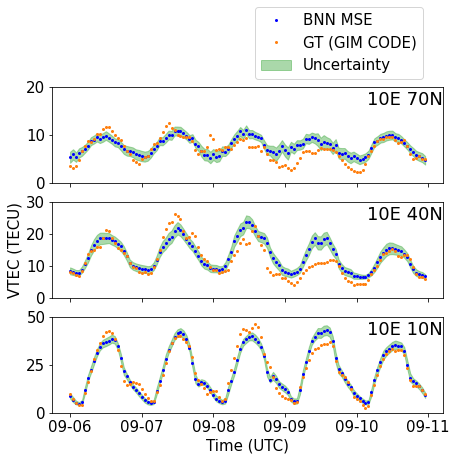

In [ ]:
from matplotlib.dates import DateFormatter
fig, axs = plt.subplots(3, sharex=True)

axs[0].plot(dates, data_BNN1_70_2017['prediction_mean_70'][5927:6047], 'bo',linewidth=1,markersize=2, label='BNN MSE')
axs[0].fill_between(dates,data_BNN1_70_2017['prediction_mean_70'] [5927:6047]- 2*data_BNN1_70_2017['prediction_std_70'][5927:6047], data_BNN1_70_2017['prediction_mean_70'] [5927:6047] + 2*data_BNN1_70_2017['prediction_std_70'][5927:6047],  alpha=0.4, color='tab:green', label='Uncertainty')
axs[0].plot(dates, data_BNN1_70_2017['targets_70'][5927:6047],   'o',color='tab:orange', linewidth=1,markersize=2, label='GT (GIM CODE)')
axs[0].set_title('10E 70N', y=0.75, loc='right')
axs[0].set_yticks((np.arange(0.0, 22.0, 10.0)))

axs[1].plot(dates, data_BNN1_40_2017['prediction_mean_40'][5927:6047], 'bo',linewidth=1,markersize=2, label='SE')
axs[1].fill_between(dates,data_BNN1_40_2017['prediction_mean_40'] [5927:6047]- 2*data_BNN1_40_2017['prediction_std_40'][5927:6047], data_BNN1_40_2017['prediction_mean_40'] [5927:6047] + 2*data_BNN1_40_2017['prediction_std_40'][5927:6047],  alpha=0.4, color='tab:green', label='Ensemble spread')
axs[1].plot(dates, data_BNN1_40_2017['targets_40'][5927:6047],   'o',color='tab:orange', linewidth=1,markersize=2, label='Ground truth (GIM CODE)')
axs[1].set_title('10E 40N', y=0.75, loc='right')
axs[1].set(ylabel='VTEC (TECU)')
axs[1].set_yticks((np.arange(0.0, 32.0, 10.0)))

axs[2].plot(dates, data_BNN1_10_2017['prediction_mean_10'][5927:6047], 'bo',linewidth=1,markersize=2, label='SE')
axs[2].fill_between(dates,data_BNN1_10_2017['prediction_mean_10'] [5927:6047]- 2*data_BNN1_10_2017['prediction_std_10'][5927:6047], data_BNN1_10_2017['prediction_mean_10'] [5927:6047] + 2*data_BNN1_10_2017['prediction_std_10'][5927:6047],  alpha=0.4, color='tab:green', label='Ensemble spread')
axs[2].plot(dates, data_BNN1_10_2017['targets_10'][5927:6047],   'o',color='tab:orange', linewidth=1,markersize=2, label='Ground truth (GIM CODE)')
axs[2].set_title('10E 10N', y=0.75, loc='right')
axs[2].set_yticks((np.arange(0.0, 52.0, 25.0)))
axs[2].set(xlabel='Time (UTC)')

axs[0].legend(loc="best", bbox_to_anchor=(0.5, 1, 0, 0))
date_form = DateFormatter("%m-%d")
axs[2].xaxis.set_major_formatter(date_form)

plt.rcParams ['figure.figsize'] = [7.0, 6.0]
plt.show()
plt.rcParams.update({'font.size': 15})

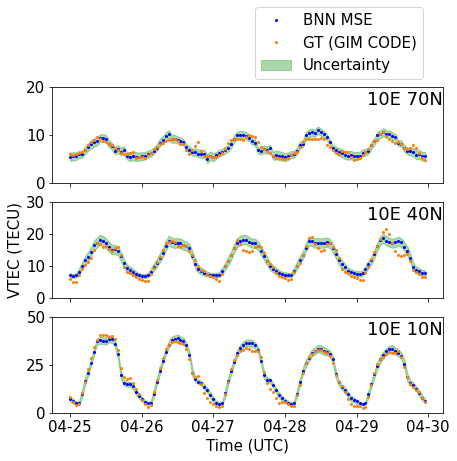

In [ ]:
from matplotlib.dates import DateFormatter
fig, axs = plt.subplots(3, sharex=True)

axs[0].plot(dates2, data_BNN1_70_2017['prediction_mean_70'][2712:2832], 'bo',linewidth=1,markersize=2, label='BNN MSE')
axs[0].fill_between(dates2,data_BNN1_70_2017['prediction_mean_70'] [2712:2832]- 2*data_BNN1_70_2017['prediction_std_70'][2712:2832], data_BNN1_70_2017['prediction_mean_70'][2712:2832] + 2*data_BNN1_70_2017['prediction_std_70'][2712:2832],  alpha=0.4, color='tab:green', label='Uncertainty')
axs[0].plot(dates2, data_BNN1_70_2017['targets_70'][2712:2832],   'o',color='tab:orange', linewidth=1,markersize=2, label='GT (GIM CODE)')
axs[0].set_title('10E 70N', y=0.75, loc='right')
axs[0].set_yticks((np.arange(0.0, 22.0, 10.0)))

axs[1].plot(dates2, data_BNN1_40_2017['prediction_mean_40'][2712:2832], 'bo',linewidth=1,markersize=2, label='SE')
axs[1].fill_between(dates2,data_BNN1_40_2017['prediction_mean_40'] [2712:2832]- 2*data_BNN1_40_2017['prediction_std_40'][2712:2832], data_BNN1_40_2017['prediction_mean_40'] [2712:2832] + 2*data_BNN1_40_2017['prediction_std_40'][2712:2832],  alpha=0.4, color='tab:green', label='Ensemble spread')
axs[1].plot(dates2, data_BNN1_40_2017['targets_40'][2712:2832],   'o',color='tab:orange', linewidth=1,markersize=2, label='Ground truth (GIM CODE)')
axs[1].set_title('10E 40N', y=0.75, loc='right')
axs[1].set(ylabel='VTEC (TECU)')
axs[1].set_yticks((np.arange(0.0, 32.0, 10.0)))

axs[2].plot(dates2, data_BNN1_10_2017['prediction_mean_10'][2712:2832], 'bo',linewidth=1,markersize=2, label='SE')
axs[2].fill_between(dates2,data_BNN1_10_2017['prediction_mean_10'] [2712:2832] - 2*data_BNN1_10_2017['prediction_std_10'][2712:2832], data_BNN1_10_2017['prediction_mean_10'] [2712:2832] + 2*data_BNN1_10_2017['prediction_std_10'][2712:2832],  alpha=0.4, color='tab:green', label='Ensemble spread')
axs[2].plot(dates2, data_BNN1_10_2017['targets_10'][2712:2832],   'o',color='tab:orange', linewidth=1,markersize=2, label='Ground truth (GIM CODE)')
axs[2].set_title('10E 10N', y=0.75, loc='right')
axs[2].set_yticks((np.arange(0.0, 52.0, 25.0)))
axs[2].set(xlabel='Time (UTC)')

axs[0].legend(loc="best", bbox_to_anchor=(0.5, 1, 0, 0))
date_form = DateFormatter("%m-%d")
axs[2].xaxis.set_major_formatter(date_form)

plt.rcParams ['figure.figsize'] = [7.0, 6.0]
plt.show()
plt.rcParams.update({'font.size': 15})

### **Statistics**

In [ ]:
import time
start = time.time()

y_pred = bnn_model_full_lowVTEC.predict(test_X)

end = time.time()
print(end - start, "seconds")

1.3712751865386963 seconds


In [ ]:
print('10E 70N (2017)')
print('BNN1 RMSE:', round(np.sqrt(metrics.mean_squared_error(targets_70, prediction_mean_70 )),2))
print('BNN1 Corr.:',  scipy.stats.pearsonr(targets_70, prediction_mean_70 )[0])
print('BNN1 MAE:',  round(metrics.mean_absolute_error(targets_70, prediction_mean_70 ),2))

print('Max std:', round(prediction_std_70.max(axis=0), 2))
print('Min std:', round(prediction_std_70.min(axis=0),2))
print('Mean std:', round(prediction_std_70.mean(axis=0), 2))

10E 70N (2017)
BNN1 RMSE: 1.18
BNN1 Corr.: 0.9051923650310106
BNN1 MAE: 0.94
Max std: 0.71
Min std: 0.12
Mean std: 0.39


In [ ]:
print('10E 10N (2017)')
print('BNN1 RMSE:', round(np.sqrt(metrics.mean_squared_error(targets_10, prediction_mean_10 )),2))
print('BNN1 Corr.:',  scipy.stats.pearsonr(targets_10, prediction_mean_10 )[0])
print('BNN1 MAE:',  round(metrics.mean_absolute_error(targets_10, prediction_mean_10 ),2))

print('Max std:', round(prediction_std_10.max(axis=0), 2))
print('Min std:', round(prediction_std_10.min(axis=0),2))
print('Mean std:', round(prediction_std_10.mean(axis=0), 2))

10E 10N (2017)
BNN1 RMSE: 2.28
BNN1 Corr.: 0.9770260808997459
BNN1 MAE: 1.79
Max std: 1.49
Min std: 0.15
Mean std: 0.83


In [ ]:
print('10E 70N (6-10 Sept 2017)')
print('BNN1 RMSE:', round(np.sqrt(metrics.mean_squared_error(targets_70[5928:6048], prediction_mean_70[5928:6048] )),2))
print('BNN1 Corr.:',  scipy.stats.pearsonr(targets_70[5928:6048], prediction_mean_70[5928:6048] )[0])
print('BNN1 MAE:',  round(metrics.mean_absolute_error(targets_70[5928:6048], prediction_mean_70[5928:6048]),2))

print('Max std:', round(prediction_std_70[5928:6048].max(axis=0), 2))
print('Min std:', round(prediction_std_70[5928:6048].min(axis=0),2))
print('Mean std:', round(prediction_std_70[5928:6048].mean(axis=0), 2))

10E 70N (6-10 Sept 2017)
BNN1 RMSE: 1.79
BNN1 Corr.: 0.7282811872758118
BNN1 MAE: 1.43
Max std: 0.7
Min std: 0.38
Mean std: 0.49


In [ ]:
print('10E 40N (6-10 Sept 2017)')
print('BNN1 RMSE:', round(np.sqrt(metrics.mean_squared_error(targets_40[5928:6048], prediction_mean_40[5928:6048] )),2))
print('BNN1 Corr.:',  scipy.stats.pearsonr(targets_40[5928:6048], prediction_mean_40[5928:6048] )[0])
print('BNN1 MAE:',  round(metrics.mean_absolute_error(targets_40[5928:6048], prediction_mean_40[5928:6048]),2))

print('Max std:', round(prediction_std_40[5928:6048].max(axis=0), 2))
print('Min std:', round(prediction_std_40[5928:6048].min(axis=0),2))
print('Mean std:', round(prediction_std_40[5928:6048].mean(axis=0), 2))

10E 40N (6-10 Sept 2017)
BNN1 RMSE: 3.09
BNN1 Corr.: 0.8544743187523384
BNN1 MAE: 2.37
Max std: 1.05
Min std: 0.29
Mean std: 0.72


In [ ]:
print('10E 10N (6-10 Sept 2017)')
print('BNN1 RMSE:', round(np.sqrt(metrics.mean_squared_error(targets_10[5928:6048], prediction_mean_10[5928:6048] )),2))
print('BNN1 Corr.:',  scipy.stats.pearsonr(targets_10[5928:6048], prediction_mean_10[5928:6048] )[0])
print('BNN1 MAE:',  round(metrics.mean_absolute_error(targets_10[5928:6048], prediction_mean_10[5928:6048]),2))

print('Max std:', round(prediction_std_10[5928:6048].max(axis=0), 2))
print('Min std:', round(prediction_std_10[5928:6048].min(axis=0),2))
print('Mean std:', round(prediction_std_10[5928:6048].mean(axis=0), 2))

10E 10N (6-10 Sept 2017)
BNN1 RMSE: 3.45
BNN1 Corr.: 0.9615987644012608
BNN1 MAE: 2.76
Max std: 1.36
Min std: 0.37
Mean std: 0.89


In [ ]:
#quiet period
print('10E 70N (25-29 April 2017)')
print('BNN1 RMSE:', round(np.sqrt(metrics.mean_squared_error(targets_70[2712:2832], prediction_mean_70[2712:2832] )),2))
print('BNN1 Corr.:', scipy.stats.pearsonr(targets_70[2712:2832], prediction_mean_70[2712:2832] )[0])
print('BNN1 MAE:',  round(metrics.mean_absolute_error(targets_70[2712:2832], prediction_mean_40[2712:2832] ),2))

print('Max std:', round(prediction_std_70[2712:2832].max(axis=0), 2))
print('Min std:', round(prediction_std_70[2712:2832].min(axis=0),2))
print('Mean std:', round(prediction_std_70[2712:2832].mean(axis=0), 2))

10E 70N (10-14 May 2017)
BNN1 RMSE: 0.73
BNN1 Corr.: 0.9017174472644419
BNN1 MAE: 0.57
Max std: 0.48
Min std: 0.3
Mean std: 0.39


In [ ]:
print('10E 40N (25-29 April 2017)')
print('BNN1 RMSE:', round(np.sqrt(metrics.mean_squared_error(targets_40[2712:2832], prediction_mean_40[2712:2832] )),2))
print('BNN1 Corr.:', scipy.stats.pearsonr(targets_40[2712:2832], prediction_mean_40[2712:2832] )[0])
print('BNN1 MAE:',  round(metrics.mean_absolute_error(targets_40[2712:2832], prediction_mean_40[2712:2832] ),2))

print('Max std:', round(prediction_std_40[2712:2832].max(axis=0), 2))
print('Min std:', round(prediction_std_40[2712:2832].min(axis=0),2))
print('Mean std:', round(prediction_std_40[2712:2832].mean(axis=0), 2))

10E 40N (10-14 May 2017)
BNN1 RMSE: 1.4
BNN1 Corr.: 0.9584677167193789
BNN1 MAE: 1.1
Max std: 0.82
Min std: 0.31
Mean std: 0.62


In [ ]:
print('10E 10N (25-29 April 2017)')
print('BNN1 RMSE:', round(np.sqrt(metrics.mean_squared_error(targets_10[2712:2832], prediction_mean_10[2712:2832] )),2))
print('BNN1 Corr.:', scipy.stats.pearsonr(targets_10[2712:2832], prediction_mean_10[2712:2832] )[0])
print('BNN1 MAE:',  round(metrics.mean_absolute_error(targets_10[2712:2832], prediction_mean_10[2712:2832] ),2))

print('Max std:', round(prediction_std_10[2712:2832].max(axis=0), 2))
print('Min std:', round(prediction_std_10[2712:2832].min(axis=0),2))
print('Mean std:', round(prediction_std_10[2712:2832].mean(axis=0), 2))

10E 10N (25-29 April 2017)
BNN1 RMSE: 1.9
BNN1 Corr.: 0.9886881751574874
BNN1 MAE: 1.57
Max std: 1.2
Min std: 0.27
Mean std: 0.8


## Bayesian Neural Network with NLL loss

In the previous model, distributions were modeled over weights, but individual point estimates (VTEC) was provided for each input.
We can also model an output distribution, keeping the learning distribution over the weights as well. The last layer will be changed to parameterize the output. The negative log-likelihood (NLL) of this distribution is used as the loss function instead of the MSE. The NLL loss is also known as the negative logarithm of predictive density (NLPD). This approach is intended to model *aleatory uncertainty (data uncertainty)*, the irreducible noise in the data, and thus capture the stochastic nature of the process that generates the data.

In [ ]:
learning_rate = 0.01

def run_experiment(model, loss, num_epochs, num_batch_size, train_X, train_y):
    model.compile(
        optimizer=keras.optimizers.SGD(learning_rate=learning_rate),
        loss=loss,
        metrics=[keras.metrics.RootMeanSquaredError()],
    )
    count = 1
    xtrain_err = 0
    xval_err = 0
    splits=20 

    for train_index, test_index in tscv.split(train_X, train_y):
      X_train, X_val =train_X[train_index], train_X[test_index]
      y_train, y_val = train_y[train_index], train_y[test_index]
      
      history=model.fit(X_train, y_train, epochs=num_epochs, batch_size=num_batch, validation_data=(X_val, y_val))
      _, rmset = model.evaluate(X_train, y_train, verbose=0)
      print('Fold {}'.format(count))
      print(f"Train RMSE: {round(rmset, 3)}")
      
      _, rmsev = model.evaluate(X_val, y_val, verbose=0)
      print(f"Valid RMSE: {round(rmsev, 3)}")

      xtrain_err+=rmset
      xval_err+=rmsev
      
      count = count + 1
    
    train_rmse = xtrain_err/splits
    val_rmse = xval_err/splits
    print ('Average RMSE on train data', round(train_rmse,3))
    print ('Average RMSE on val data', round(val_rmse,3))

In [ ]:
learning_rate = 0.1

def run_experiment(model, loss, num_epochs, num_batch_size, train_X, train_y):
    model.compile(
        optimizer=keras.optimizers.SGD(learning_rate=learning_rate),
        loss=loss,
        metrics=[keras.metrics.RootMeanSquaredError()],
    )
    count = 1
    xtrain_err = 0
    xval_err = 0
    splits=20 

    for train_index, test_index in tscv.split(train_X, train_y):
      X_train, X_val =train_X[train_index], train_X[test_index]
      y_train, y_val = train_y[train_index], train_y[test_index]
      
      history=model.fit(X_train, y_train, epochs=num_epochs, batch_size=num_batch, validation_data=(X_val, y_val))
      _, rmset = model.evaluate(X_train, y_train, verbose=0)
      print('Fold {}'.format(count))
      print(f"Train RMSE: {round(rmset, 3)}")
      
      _, rmsev = model.evaluate(X_val, y_val, verbose=0)
      print(f"Valid RMSE: {round(rmsev, 3)}")

      xtrain_err+=rmset
      xval_err+=rmsev
      
      count = count + 1
    
    train_rmse = xtrain_err/splits
    val_rmse = xval_err/splits
    print ('Average RMSE on train data', round(train_rmse,3))
    print ('Average RMSE on val data', round(val_rmse,3))

To provide the mean and variance as output of the model,  a custom output layer with two neurons will be created: for the mean VTEC output and for the standard deviation.  

In [249]:
def create_probabilistic_bnn_model(input_dim, hidden_units, kl_weight):
    inputs = layers.Input(shape=(input_dim,))
    features = layers.BatchNormalization()(inputs)

    # Create hidden layers with weight uncertainty using the DenseVariational layer.
    for units in hidden_units:
        features = tfp.layers.DenseVariational(
            units=units,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=kl_weight,
            activation="sigmoid",
        )(features)

    distribution_params = layers.Dense(units=2)(features)
    outputs = tfp.layers.IndependentNormal(1)(distribution_params)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


In [ ]:
def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)

In [250]:
bnn_model_probabilistic_lowVTEC = create_probabilistic_bnn_model(16, [32], 1/train_X.size)
bnn_model_probabilistic_lowVTEC.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 16)]              0         
                                                                 
 batch_normalization_5 (Batc  (None, 16)               64        
 hNormalization)                                                 
                                                                 
 dense_variational_10 (Dense  (None, 32)               148784    
 Variational)                                                    
                                                                 
 dense_16 (Dense)            (None, 2)                 66        
                                                                 
 independent_normal (Indepen  ((None, 1),              0         
 dentNormal)                  (None, 1))                         
                                                          

In [ ]:
bnn_model_probabilistic_midVTEC = create_probabilistic_bnn_model(16, [32], 1/train_X.size)
bnn_model_probabilistic_midVTEC.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16)]              0         
                                                                 
 batch_normalization (BatchN  (None, 16)               64        
 ormalization)                                                   
                                                                 
 dense_variational (DenseVar  (None, 32)               148784    
 iational)                                                       
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
 independent_normal (Indepen  ((None, 1),              0         
 dentNormal)                  (None, 1))                         
                                                             

In [ ]:
bnn_model_probabilistic_highVTEC = create_probabilistic_bnn_model(16, [32], 1/train_X.size)
bnn_model_probabilistic_highVTEC.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16)]              0         
                                                                 
 batch_normalization_1 (Batc  (None, 16)               64        
 hNormalization)                                                 
                                                                 
 dense_variational (DenseVar  (None, 32)               148784    
 iational)                                                       
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
 independent_normal (Indepen  ((None, 1),              0         
 dentNormal)                  (None, 1))                         
                                                             

In [ ]:
num_epochs= 2000
num_batch= 500
#Learning_rate = 0.1

import time
start = time.time()

run_experiment(bnn_model_probabilistic_lowVTEC, negative_loglikelihood, num_epochs,num_batch,  train_X, train_y)

end = time.time()
print(end - start, "seconds")

In [ ]:
num_epochs = 2000
num_batch= 500
#Learning_rate = 0.01

import time
start = time.time()

run_experiment(bnn_model_probabilistic_midVTEC, negative_loglikelihood, num_epochs,num_batch,  train_X, train_y)

end = time.time()
print(end - start, "seconds")

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
32/32 [==============================] - 0s 6ms/step - loss: 2.3488 - root_mean_squared_error: 4.4024 - val_loss: 1.9590 - val_root_mean_squared_error: 2.6813
Epoch 1506/2000
32/32 [==============================] - 0s 6ms/step - loss: 2.3532 - root_mean_squared_error: 4.4100 - val_loss: 1.8840 - val_root_mean_squared_error: 2.7814
Epoch 1507/2000
32/32 [==============================] - 0s 6ms/step - loss: 2.3509 - root_mean_squared_error: 4.3835 - val_loss: 1.8581 - val_root_mean_squared_error: 2.6719
Epoch 1508/2000
32/32 [==============================] - 0s 5ms/step - loss: 2.3520 - root_mean_squared_error: 4.4014 - val_loss: 1.8671 - val_root_mean_squared_error: 2.5708
Epoch 1509/2000
32/32 [==============================] - 0s 5ms/step - loss: 2.3474 - root_mean_squared_error: 4.3788 - val_loss: 1.8463 - val_root_mean_squared_error: 2.5359
Epoch 1510/2000
32/32 [==============================] - 0s 6ms/step - los

In [ ]:
#Learning_rate=0.01
num_epochs =2000
num_batch= 500

import time
start = time.time()

run_experiment(bnn_model_probabilistic_highVTEC, negative_loglikelihood, num_epochs,num_batch,  train_X, train_y)

end = time.time()
print(end - start, "seconds")

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
32/32 [==============================] - 0s 8ms/step - loss: 1.9783 - root_mean_squared_error: 2.8632 - val_loss: 1.5542 - val_root_mean_squared_error: 1.7924
Epoch 1506/2000
32/32 [==============================] - 0s 8ms/step - loss: 1.9820 - root_mean_squared_error: 2.8929 - val_loss: 1.5393 - val_root_mean_squared_error: 1.7404
Epoch 1507/2000
32/32 [==============================] - 0s 8ms/step - loss: 1.9780 - root_mean_squared_error: 2.8622 - val_loss: 1.5039 - val_root_mean_squared_error: 1.6705
Epoch 1508/2000
32/32 [==============================] - 0s 8ms/step - loss: 1.9948 - root_mean_squared_error: 2.8445 - val_loss: 1.5190 - val_root_mean_squared_error: 1.7678
Epoch 1509/2000
32/32 [==============================] - 0s 8ms/step - loss: 1.9897 - root_mean_squared_error: 2.8452 - val_loss: 1.4970 - val_root_mean_squared_error: 1.7543
Epoch 1510/2000
32/32 [==============================] - 0s 8ms/step - los

### **Testing**

In [ ]:
samples=10

In [ ]:
prediction_distribution_10 = bnn_model_probabilistic_lowVTEC(test_X_10_scaled)
prediction_mean_aleatoric_10 = prediction_distribution_10.mean().numpy().tolist()
prediction_aleatoric_std_10 = prediction_distribution_10.stddev().numpy() 

# The 95% CI is computed as mean ± (2 * stdv)
upper_aleatoric_10 = (prediction_mean_aleatoric_10 + (2 * prediction_aleatoric_std_10)).tolist()
lower_aleatoric_10 = (prediction_mean_aleatoric_10 - (2 * prediction_aleatoric_std_10)).tolist()
prediction_aleatoric_stdv_10 = prediction_aleatoric_std_10.tolist()

for idx in range(samples):
    print(
        f"Prediction mean: {round(prediction_mean_aleatoric_10[idx][0], 2)}, "
        f"stddev: {round(prediction_aleatoric_stdv_10[idx][0], 2)}, "
        f"95% CI: [{round(upper_aleatoric_10[idx][0], 2)} - {round(lower_aleatoric_10[idx][0], 2)}]"
        f" - Actual: {y_10_test_new[idx]}"
    )

Prediction mean: 6.11, stddev: 1.97, 95% CI: [10.05 - 2.16] - Actual: 5.6
Prediction mean: 6.11, stddev: 1.97, 95% CI: [10.05 - 2.16] - Actual: 4.7
Prediction mean: 6.08, stddev: 1.97, 95% CI: [10.02 - 2.14] - Actual: 3.5
Prediction mean: 4.48, stddev: 1.91, 95% CI: [8.3 - 0.66] - Actual: 3.1
Prediction mean: 10.18, stddev: 1.61, 95% CI: [13.39 - 6.97] - Actual: 6.8
Prediction mean: 10.22, stddev: 1.61, 95% CI: [13.44 - 6.99] - Actual: 12.1
Prediction mean: 17.75, stddev: 2.29, 95% CI: [22.34 - 13.16] - Actual: 17.0
Prediction mean: 22.35, stddev: 2.8, 95% CI: [27.95 - 16.75] - Actual: 21.3
Prediction mean: 25.61, stddev: 3.08, 95% CI: [31.77 - 19.46] - Actual: 23.1
Prediction mean: 26.98, stddev: 3.3, 95% CI: [33.58 - 20.39] - Actual: 24.2


In [ ]:
upper_d=np.array(upper_aleatoric_10)
lower_d=np.array(lower_aleatoric_10)
upperr_10 = upper_d.flatten()
lowerr_10 = lower_d.flatten()

In [ ]:
prediction_distribution_40 = bnn_model_probabilistic_midVTEC(test_X_40_scaled)
prediction_mean_aleatoric_40 = prediction_distribution_40.mean().numpy().tolist()
prediction_aleatoric_std_40 = prediction_distribution_40.stddev().numpy() 

# The 95% CI is computed as mean ± (2 * stdv)
upper_aleatoric_40 = (prediction_mean_aleatoric_40 + (2 * prediction_aleatoric_std_40)).tolist()
lower_aleatoric_40 = (prediction_mean_aleatoric_40 - (2 * prediction_aleatoric_std_40)).tolist()
prediction_aleatoric_stdv_40 = prediction_aleatoric_std_40.tolist()

for idx in range(samples):
    print(
        f"Prediction mean: {round(prediction_mean_aleatoric_40[idx][0], 2)}, "
        f"stddev: {round(prediction_aleatoric_stdv_40[idx][0], 2)}, "
        f"95% CI: [{round(upper_aleatoric_40[idx][0], 2)} - {round(lower_aleatoric_40[idx][0], 2)}]"
        f" - Actual: {y_40_test_new[idx]}"
    )

Prediction mean: 6.2, stddev: 1.18, 95% CI: [8.56 - 3.84] - Actual: 6.9
Prediction mean: 6.3, stddev: 1.21, 95% CI: [8.72 - 3.87] - Actual: 7.8
Prediction mean: 6.26, stddev: 1.2, 95% CI: [8.65 - 3.87] - Actual: 7.3
Prediction mean: 6.31, stddev: 1.19, 95% CI: [8.7 - 3.92] - Actual: 6.6
Prediction mean: 6.53, stddev: 1.21, 95% CI: [8.95 - 4.1] - Actual: 7.2
Prediction mean: 7.36, stddev: 1.29, 95% CI: [9.95 - 4.78] - Actual: 8.4
Prediction mean: 8.84, stddev: 1.47, 95% CI: [11.79 - 5.9] - Actual: 9.0
Prediction mean: 10.37, stddev: 1.7, 95% CI: [13.77 - 6.96] - Actual: 10.2
Prediction mean: 10.98, stddev: 1.77, 95% CI: [14.51 - 7.45] - Actual: 11.2
Prediction mean: 11.87, stddev: 1.98, 95% CI: [15.84 - 7.91] - Actual: 11.5


In [ ]:
upper_d=np.array(upper_aleatoric_40)
lower_d=np.array(lower_aleatoric_40)
upperr_40 = upper_d.flatten()
lowerr_40 = lower_d.flatten()

In [ ]:
prediction_distribution_70 = bnn_model_probabilistic_highVTEC(test_X_70_scaled)
prediction_mean_aleatoric_70 = prediction_distribution_70.mean().numpy().tolist()
prediction_aleatoric_std_70 = prediction_distribution_70.stddev().numpy() 

# The 95% CI is computed as mean ± (2 * stdv)
upper_aleatoric_70 = (prediction_mean_aleatoric_70 + (2 * prediction_aleatoric_std_70)).tolist()
lower_aleatoric_70 = (prediction_mean_aleatoric_70 - (2 * prediction_aleatoric_std_70)).tolist()
prediction_aleatoric_stdv_70 = prediction_aleatoric_std_70.tolist()

for idx in range(samples):
    print(
        f"Prediction mean: {round(prediction_mean_aleatoric_70[idx][0], 2)}, "
        f"stddev: {round(prediction_aleatoric_stdv_70[idx][0], 2)}, "
        f"95% CI: [{round(upper_aleatoric_70[idx][0], 2)} - {round(lower_aleatoric_70[idx][0], 2)}]"
        f" - Actual: {y_70_test_new[idx]}"
    )

Prediction mean: 2.21, stddev: 1.15, 95% CI: [4.51 - -0.08] - Actual: 1.1
Prediction mean: 2.28, stddev: 1.18, 95% CI: [4.63 - -0.07] - Actual: 0.8
Prediction mean: 2.24, stddev: 1.11, 95% CI: [4.46 - 0.01] - Actual: 0.9
Prediction mean: 1.7, stddev: 1.03, 95% CI: [3.75 - -0.36] - Actual: 1.3
Prediction mean: 1.82, stddev: 1.06, 95% CI: [3.94 - -0.3] - Actual: 1.3
Prediction mean: 1.75, stddev: 1.02, 95% CI: [3.8 - -0.3] - Actual: 1.0
Prediction mean: 1.62, stddev: 1.02, 95% CI: [3.65 - -0.42] - Actual: 0.9
Prediction mean: 2.08, stddev: 1.05, 95% CI: [4.19 - -0.02] - Actual: 1.3
Prediction mean: 2.46, stddev: 1.08, 95% CI: [4.63 - 0.3] - Actual: 2.1
Prediction mean: 3.09, stddev: 1.11, 95% CI: [5.31 - 0.87] - Actual: 2.4


In [ ]:
upper_d=np.array(upper_aleatoric_70)
lower_d=np.array(lower_aleatoric_70)
upperr_70 = upper_d.flatten()
lowerr_70 = lower_d.flatten()

### **In-out (percentage)**

In [ ]:
#Test data of year 2017
diff_up_10 = upperr_10 - targets_10
diff_low_10 = lowerr_10 - targets_10
diff_up_40 = upperr_40 - targets_40
diff_low_40 = lowerr_40 - targets_40
diff_up_70 = upperr_70 - targets_70
diff_low_70 = lowerr_70 - targets_70

In [ ]:
#Test data September 6-10,2017
diff_up_10_sep = upperr_10[5927:6047] - targets_10[5927:6047]
diff_low_10_sep = lowerr_10[5927:6047] - targets_10[5927:6047]
diff_up_40_sep = upperr_40[5927:6047] - targets_40[5927:6047]
diff_low_40_sep = lowerr_40[5927:6047] - targets_40[5927:6047]
diff_up_70_sep = upperr_70[5927:6047] - targets_70[5927:6047]
diff_low_70_sep = lowerr_70[5927:6047] - targets_70[5927:6047]

In [ ]:
#Test data April 25-29,2017
diff_up_10_apr = upperr_10[2712:2832] - targets_10[2712:2832]
diff_low_10_apr = lowerr_10[2712:2832] - targets_10[2712:2832]
diff_up_40_apr = upperr_40[2712:2832] - targets_40[2712:2832]
diff_low_40_apr = lowerr_40[2712:2832]- targets_40[2712:2832]
diff_up_70_apr = upperr_70[2712:2832] - targets_70[2712:2832]
diff_low_70_apr = lowerr_70[2712:2832] - targets_70[2712:2832]

In [ ]:
diff_up_10.size

8758

In [ ]:
data_2017_len=8758
data_apr_sep_len=120

In [ ]:
a=0
b=0
for i in range(data_2017_len):
  if np.any((diff_up_10.values[i] >= 0) & (diff_low_10.values[i] <= 0)):
    a=a+1
  else:
    b=b+1

In [ ]:
whole= a+b
percent_in_CI_10 = a/whole * 100
percent_out_CI_10 = b/whole * 100

In [ ]:
#2017, 10E 10N
percent_in_CI_10

97.38524777346426

In [ ]:
#September 6-10,2017, 10E 10N
percent_in_CI_10

98.33333333333333

In [ ]:
#April 25-29,2017, 10E 10N
percent_in_CI_10

100.0

In [ ]:
a=0
b=0
for i in range(data_2017_len):
  if np.any((diff_up_40.values[i] >= 0) & (diff_low_40.values[i] <= 0)):
    a=a+1
  else:
    b=b+1

In [ ]:
whole= a+b
percent_in_CI_40 = a/whole * 100
percent_out_CI_40 = b/whole * 100

In [ ]:
#2017, 10E 40N
percent_in_CI_40

95.1130395067367

In [ ]:
#September 6-10,2017, 10E 40N
percent_in_CI_40

93.33333333333333

In [ ]:
#April 25-29,2017, 10E 40N
percent_in_CI_40

99.16666666666667

In [ ]:
a=0
b=0
for i in range(data_2017_len):
  if np.any((diff_up_70.values[i] >= 0) & (diff_low_70.values[i] <= 0)):
    a=a+1
  else:
    b=b+1

In [ ]:
whole= a+b
percent_in_CI_70 = a/whole * 100
percent_out_CI_70 = b/whole * 100

In [ ]:
#2017, 10E 70N
percent_in_CI_70

96.74583238182234

In [ ]:
#September 6-10,2017, 10E 70N
percent_in_CI_70

90.83333333333333

In [ ]:
#April 25-29,2017, 10E 70N
percent_in_CI_70

100.0

### **Figures**

In [ ]:
from matplotlib.dates import DateFormatter
base = datetime.datetime(2017, 9, 6)
dates = np.array([base + datetime.timedelta(hours=(1 * j))
                  for j in range(120)])

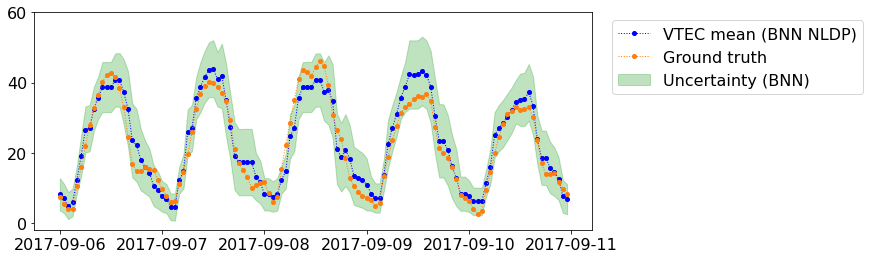

In [ ]:
plt.plot(dates,prediction_mean_aleatoric_10[5928:6048], 'bo:',linewidth=1,markersize=4, label='VTEC mean (BNN NLDP)')
plt.plot(dates,targets_10[5928:6048], 'o:',color='tab:orange', linewidth=1,markersize=4,  label='Ground truth')
plt.fill_between(dates, lowerr_10[5928:6048], upperr_10[5928:6048], alpha=0.3, color='tab:green',label='Uncertainty (BNN)')
plt.legend(loc="best", bbox_to_anchor=(1, 1, 0.5, 0))
plt.yticks((np.arange(0.0, 62.0, 20.0)))
plt.rcParams ['figure.figsize'] = [10.0, 4.0]
plt.show()
plt.rcParams.update({'font.size': 16})

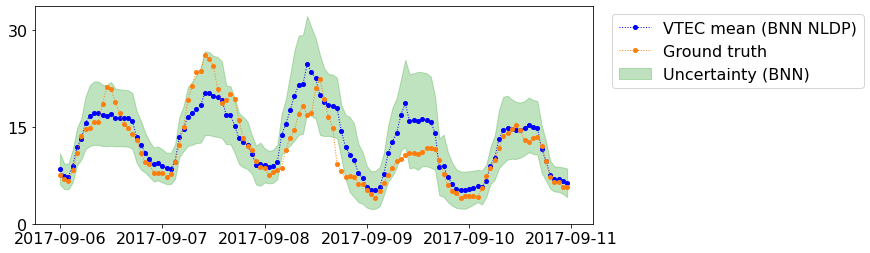

In [ ]:
plt.plot(dates,prediction_mean_aleatoric_40[5928:6048], 'bo:',linewidth=1,markersize=4, label='VTEC mean (BNN NLDP)')
plt.plot(dates,targets_40[5928:6048], 'o:',color='tab:orange', linewidth=1,markersize=4,  label='Ground truth')
plt.fill_between(dates, lowerr_40[5928:6048], upperr_40[5928:6048], alpha=0.3, color='tab:green',label='Uncertainty (BNN)')
plt.legend(loc="best", bbox_to_anchor=(1, 1, 0.5, 0))
plt.yticks((np.arange(0.0, 32.0, 15.0)))
plt.rcParams ['figure.figsize'] = [10.0, 4.0]
plt.show()
plt.rcParams.update({'font.size': 16})

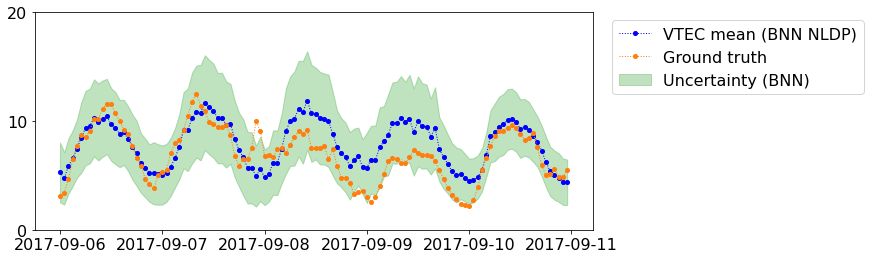

In [ ]:
plt.plot(dates,prediction_mean_aleatoric_70[5928:6048], 'bo:',linewidth=1,markersize=4, label='VTEC mean (BNN NLDP)')
plt.plot(dates,targets_70[5928:6048], 'o:',color='tab:orange', linewidth=1,markersize=4,  label='Ground truth')
plt.fill_between(dates, lowerr_70[5928:6048], upperr_70[5928:6048], alpha=0.3, color='tab:green',label='Uncertainty (BNN)')
plt.legend(loc="best", bbox_to_anchor=(1, 1, 0.5, 0))
plt.yticks((np.arange(0.0, 22.0, 10.0)))
plt.rcParams ['figure.figsize'] = [10.0, 4.0]
plt.show()
plt.rcParams.update({'font.size': 16})

In [ ]:
base = datetime.datetime(2017, 4, 25)
dates2 = np.array([base + datetime.timedelta(hours=(1 * j))
                  for j in range(120)])

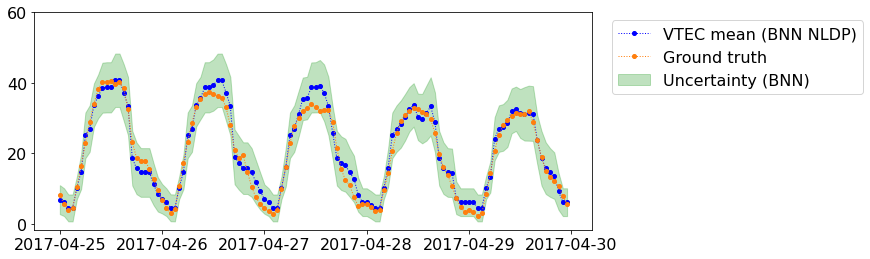

In [ ]:
plt.plot(dates2,prediction_mean_aleatoric_10[2712:2832], 'bo:',linewidth=1,markersize=4, label='VTEC mean (BNN NLDP)')
plt.plot(dates2, targets_10[2712:2832],  'o:',color='tab:orange', linewidth=1,markersize=4, label='Ground truth')
plt.fill_between(dates2, lowerr_10[2712:2832], upperr_10[2712:2832], alpha=0.3, color='tab:green',label='Uncertainty (BNN)')
plt.legend(loc="best", bbox_to_anchor=(1, 1, 0.5, 0))
plt.yticks((np.arange(0.0, 62.0, 20.0)))
plt.show()
plt.rcParams.update({'font.size': 16})

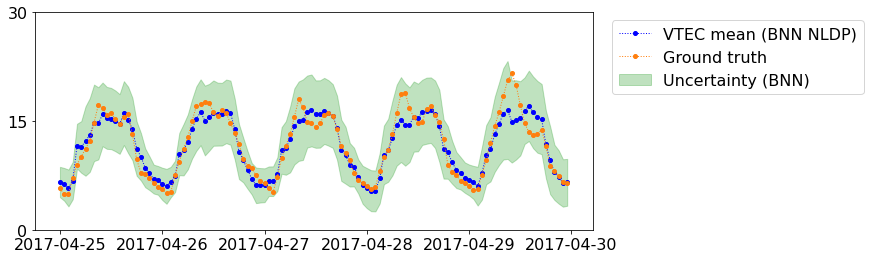

In [ ]:
plt.plot(dates2,prediction_mean_aleatoric_40[2712:2832], 'bo:',linewidth=1,markersize=4, label='VTEC mean (BNN NLDP)')
plt.plot(dates2, targets_40[2712:2832],  'o:',color='tab:orange', linewidth=1,markersize=4, label='Ground truth')
plt.fill_between(dates2, lowerr_40[2712:2832], upperr_40[2712:2832], alpha=0.3, color='tab:green',label='Uncertainty (BNN)')
plt.legend(loc="best", bbox_to_anchor=(1, 1, 0.5, 0))
plt.yticks((np.arange(0.0, 32.0, 15.0)))
plt.show()
plt.rcParams.update({'font.size': 16})

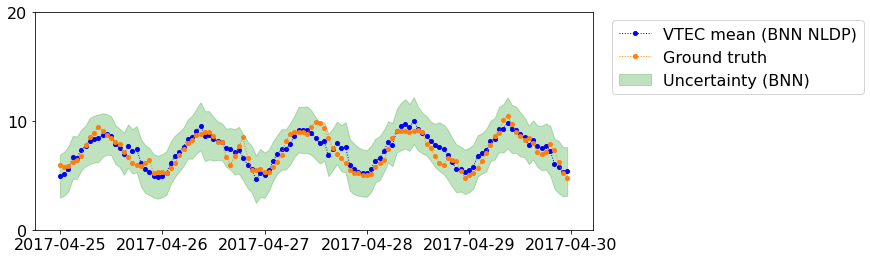

In [ ]:
plt.plot(dates2,prediction_mean_aleatoric_70[2712:2832], 'bo:',linewidth=1,markersize=4, label='VTEC mean (BNN NLDP)')
plt.plot(dates2, targets_70[2712:2832],  'o:',color='tab:orange', linewidth=1,markersize=4, label='Ground truth')
plt.fill_between(dates2, lowerr_70[2712:2832], upperr_70[2712:2832], alpha=0.3, color='tab:green',label='Uncertainty (BNN)')
plt.legend(loc="best", bbox_to_anchor=(1, 1, 0.5, 0))
plt.yticks((np.arange(0.0, 22.0, 10.0)))
plt.show()
plt.rcParams.update({'font.size': 16})

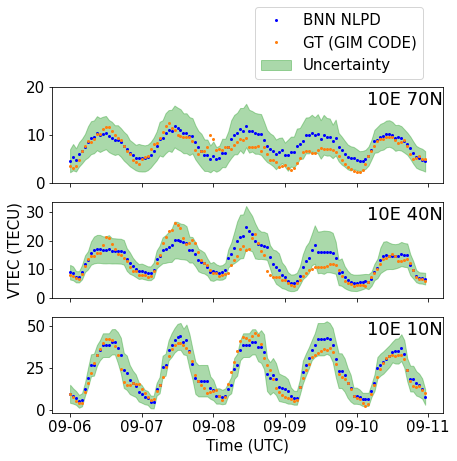

In [ ]:
fig, axs = plt.subplots(3, sharex=True)

axs[0].plot(dates, data_BNN2_70_2017['prediction_mean_aleatoric_70'][5927:6047], 'bo',linewidth=1,markersize=2, label='BNN NLPD')
axs[0].fill_between(dates,data_BNN2_70_2017['prediction_mean_aleatoric_70'] [5927:6047]- 2*data_BNN2_70_2017['prediction_std_aleatoric_70'][5927:6047], data_BNN2_70_2017['prediction_mean_aleatoric_70'] [5927:6047] + 2*data_BNN2_70_2017['prediction_std_aleatoric_70'][5927:6047],  alpha=0.4, color='tab:green', label='Uncertainty')
axs[0].plot(dates, data_BNN2_70_2017['targets_70'][5927:6047],   'o',color='tab:orange', linewidth=1,markersize=2, label='GT (GIM CODE)')
axs[0].set_title('10E 70N', y=0.75, loc='right')
axs[0].set_yticks((np.arange(0.0, 22.0, 10.0)))

axs[1].plot(dates, data_BNN2_40_2017['prediction_aleatoric_mean_40'][5927:6047], 'bo',linewidth=1,markersize=2, label='SE')
axs[1].fill_between(dates,data_BNN2_40_2017['prediction_aleatoric_mean_40'] [5927:6047]- 2*data_BNN2_40_2017['prediction_aleatoric_std_40'][5927:6047], data_BNN2_40_2017['prediction_aleatoric_mean_40'] [5927:6047] + 2*data_BNN2_40_2017['prediction_aleatoric_std_40'][5927:6047],  alpha=0.4, color='tab:green', label='Ensemble spread')
axs[1].plot(dates, data_BNN2_40_2017['targets_40'][5927:6047],   'o',color='tab:orange', linewidth=1,markersize=2, label='Ground truth (GIM CODE)')
axs[1].set_title('10E 40N', y=0.75, loc='right')
axs[1].set(ylabel='VTEC (TECU)')
axs[1].set_yticks((np.arange(0.0, 32.0, 10.0)))

axs[2].plot(dates, data_BNN2_10_2017['prediction_mean_aleatoric_10'][5927:6047], 'bo',linewidth=1,markersize=2, label='SE')
axs[2].fill_between(dates,data_BNN2_10_2017['prediction_mean_aleatoric_10'] [5927:6047]- 2*data_BNN2_10_2017['prediction_aleatoric_std_10'][5927:6047], data_BNN2_10_2017['prediction_mean_aleatoric_10'] [5927:6047] + 2*data_BNN2_10_2017['prediction_aleatoric_std_10'][5927:6047],  alpha=0.4, color='tab:green', label='Ensemble spread')
axs[2].plot(dates, data_BNN2_10_2017['targets_10'][5927:6047],   'o',color='tab:orange', linewidth=1,markersize=2, label='Ground truth (GIM CODE)')
axs[2].set_title('10E 10N', y=0.75, loc='right')
axs[2].set_yticks((np.arange(0.0, 52.0, 25.0)))
axs[2].set(xlabel='Time (UTC)')

axs[0].legend(loc="best", bbox_to_anchor=(0.5, 1, 0, 0))
date_form = DateFormatter("%m-%d")
axs[2].xaxis.set_major_formatter(date_form)

plt.rcParams ['figure.figsize'] = [7.0, 6.0]
plt.show()
plt.rcParams.update({'font.size': 15})

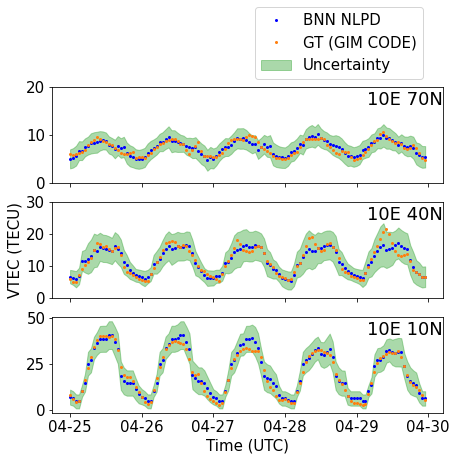

In [ ]:
fig, axs = plt.subplots(3, sharex=True)

axs[0].plot(dates2, data_BNN2_70_2017['prediction_mean_aleatoric_70'][2712:2832], 'bo',linewidth=1,markersize=2, label='BNN NLPD')
axs[0].fill_between(dates2,data_BNN2_70_2017['prediction_mean_aleatoric_70'] [2712:2832]- 2*data_BNN2_70_2017['prediction_std_aleatoric_70'][2712:2832], data_BNN2_70_2017['prediction_mean_aleatoric_70'][2712:2832] + 2*data_BNN2_70_2017['prediction_std_aleatoric_70'][2712:2832],  alpha=0.4, color='tab:green', label='Uncertainty')
axs[0].plot(dates2, data_BNN2_70_2017['targets_70'][2712:2832],   'o',color='tab:orange', linewidth=1,markersize=2, label='GT (GIM CODE)')
axs[0].set_title('10E 70N', y=0.75, loc='right')
axs[0].set_yticks((np.arange(0.0, 22.0, 10.0)))

axs[1].plot(dates2, data_BNN2_40_2017['prediction_aleatoric_mean_40'][2712:2832], 'bo',linewidth=1,markersize=2, label='BNN NLPD')
axs[1].fill_between(dates2,data_BNN2_40_2017['prediction_aleatoric_mean_40'] [2712:2832]- 2*data_BNN2_40_2017['prediction_aleatoric_std_40'][2712:2832], data_BNN2_40_2017['prediction_aleatoric_mean_40'][2712:2832] + 2*data_BNN2_40_2017['prediction_aleatoric_std_40'][2712:2832],  alpha=0.4, color='tab:green', label='Ensemble spread')
axs[1].plot(dates2, data_BNN2_40_2017['targets_40'][2712:2832],   'o',color='tab:orange', linewidth=1,markersize=2, label='Ground truth (GIM CODE)')
axs[1].set_title('10E 40N', y=0.75, loc='right')
axs[1].set(ylabel='VTEC (TECU)')
axs[1].set_yticks((np.arange(0.0, 32.0, 10.0)))

axs[2].plot(dates2, data_BNN2_10_2017['prediction_mean_aleatoric_10'][2712:2832], 'bo',linewidth=1,markersize=2, label='BNN NLPD')
axs[2].fill_between(dates2,data_BNN2_10_2017['prediction_mean_aleatoric_10'][2712:2832]- 2*data_BNN2_10_2017['prediction_aleatoric_std_10'][2712:2832], data_BNN2_10_2017['prediction_mean_aleatoric_10'] [2712:2832] + 2*data_BNN2_10_2017['prediction_aleatoric_std_10'][2712:2832],  alpha=0.4, color='tab:green', label='Ensemble spread')
axs[2].plot(dates2, data_BNN2_10_2017['targets_10'][2712:2832],   'o',color='tab:orange', linewidth=1,markersize=2, label='Ground truth (GIM CODE)')
axs[2].set_title('10E 10N', y=0.75, loc='right')
axs[2].set_yticks((np.arange(0.0, 52.0, 25.0)))
axs[2].set(xlabel='Time (UTC)')

axs[0].legend(loc="best", bbox_to_anchor=(0.5, 1, 0, 0))
date_form = DateFormatter("%m-%d")
axs[2].xaxis.set_major_formatter(date_form)

plt.rcParams ['figure.figsize'] = [7.0,6.0]
plt.show()

The plots below show a comparison of the mean VTEC forecast by the Super Ensemble (SE) model, the BNN model, and the BNN-NLL model. For further analysis and plots, see the paper "Uncertainty Quantification for Machine Learning-based Ionosphere and Space Weather Forecasting" by Natras R., Soja B. and Schmidt M.

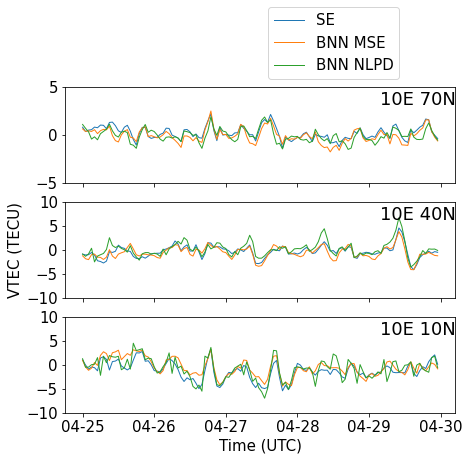

In [ ]:
#April 25-29, 2017.
fig, axs = plt.subplots(3, sharex=True)

axs[0].plot(dates2, diff_70_apr_SE,linewidth=1,markersize=2, label='SE')
axs[0].plot(dates2, diff_70_apr_BNN1,linewidth=1,markersize=2, label='BNN MSE')
axs[0].plot(dates2, diff_70_apr,linewidth=1,markersize=2, label='BNN NLPD')
axs[0].set_title('10E 70N', y=0.75, loc='right')
axs[0].set_yticks((np.arange(-5, 6.0, 5.0)))

axs[1].plot(dates2, diff_40_apr_SE, linewidth=1,markersize=2, label='SE')
axs[1].plot(dates2, diff_40_apr_BNN1, linewidth=1,markersize=2, label='BNN MSE')
axs[1].plot(dates2, diff_40_apr,linewidth=1,markersize=2, label='BNN NLPD')
axs[1].set_title('10E 40N', y=0.75, loc='right')
axs[1].set(ylabel='VTEC (TECU)')
axs[1].set_yticks((np.arange(-10, 11.0, 5.0)))

axs[2].plot(dates2, diff_10_apr_SE, linewidth=1,markersize=2, label='SE')
axs[2].plot(dates2, diff_10_apr_BNN1, linewidth=1,markersize=2, label='BNN MSE')
axs[2].plot(dates2, diff_10_apr,linewidth=1,markersize=2, label='BNN NLPD')
axs[2].set_title('10E 10N', y=0.75, loc='right')
axs[2].set_yticks((np.arange(-10, 11.0, 5.0)))
axs[2].set(xlabel='Time (UTC)')

axs[0].legend(loc="best", bbox_to_anchor=(0.5, 1, 0, 0))
date_form = DateFormatter("%m-%d")
axs[2].xaxis.set_major_formatter(date_form)

plt.rcParams ['figure.figsize'] = [7.0, 6.0]
plt.show()

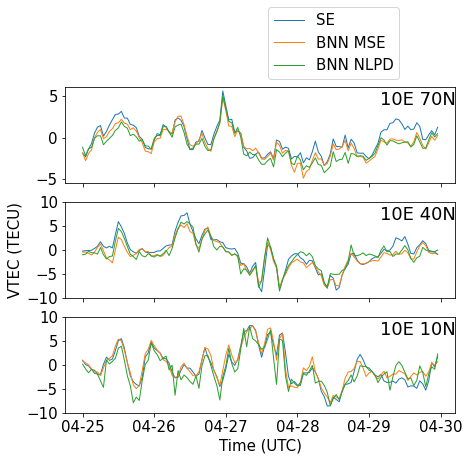

In [ ]:
#September 6-10, 2017. Note: incorrect dates in the figure.
fig, axs = plt.subplots(3, sharex=True)

axs[0].plot(dates, diff_70_sept_SE,linewidth=1,markersize=2, label='SE')
axs[0].plot(dates, diff_70_sept_BNN1,linewidth=1,markersize=2, label='BNN MSE')
axs[0].plot(dates, diff_70_sept,linewidth=1,markersize=2, label='BNN NLPD')
#axs[0].fill_between(dates2,diff_70_apr- 2*data_BNN2_70_2017['prediction_std_aleatoric_70'][2712:2832], diff_70_apr + 2*data_BNN2_70_2017['prediction_std_aleatoric_70'][2712:2832],  alpha=0.4, color='tab:green', label='Uncertainty')
#axs[0].plot(dates2, data_BNN2_70_2017['targets_70'][5927:6047],   'o',color='tab:orange', linewidth=1,markersize=2, label='GT (GIM CODE)')
axs[0].set_title('10E 70N', y=0.75, loc='right')
axs[0].set_yticks((np.arange(-5, 6.0, 5.0)))

axs[1].plot(dates, diff_40_sept_SE, linewidth=1,markersize=2, label='SE')
axs[1].plot(dates, diff_40_sept_BNN1, linewidth=1,markersize=2, label='BNN MSE')
axs[1].plot(dates, diff_40_sept, linewidth=1,markersize=2, label='BNN NLPD')
axs[1].set_title('10E 40N', y=0.75, loc='right')
axs[1].set(ylabel='VTEC (TECU)')
axs[1].set_yticks((np.arange(-10, 11.0, 5.0)))

axs[2].plot(dates, diff_10_sept_SE, linewidth=1,markersize=2, label='SE')
axs[2].plot(dates, diff_10_sept_BNN1, linewidth=1,markersize=2, label='BNN MSE')
axs[2].plot(dates, diff_10_sept, linewidth=1,markersize=2, label='BNN NLPD')
axs[2].set_title('10E 10N', y=0.75, loc='right')
axs[2].set_yticks((np.arange(-10, 11.0, 5.0)))
axs[2].set(xlabel='Time (UTC)')

axs[0].legend(loc="best", bbox_to_anchor=(0.5, 1, 0, 0))
date_form = DateFormatter("%m-%d")
axs[2].xaxis.set_major_formatter(date_form)

plt.rcParams ['figure.figsize'] = [7.0, 6.0]
plt.show()

### **Statistics**

In [ ]:
start = time.time()

y_pred = bnn_model_probabilistic_lowVTEC.predict(test_X)

end = time.time()
print(end - start, "seconds")

101.78639101982117 seconds


In [ ]:
start = time.time()

y_pred = bnn_model_probabilistic_lowVTEC.predict(test_X)

end = time.time()
print(end - start, "seconds")

1.3966546058654785 seconds


In [ ]:
print('10E 70N (2017)')
print('BNN1 RMSE:', round(np.sqrt(metrics.mean_squared_error(targets_70, prediction_mean_aleatoric_70 )),2))
print('BNN1 Corr.:',  scipy.stats.pearsonr(targets_70, prediction_mean_aleatoric_70 )[0])
print('BNN1 MAE:',  round(metrics.mean_absolute_error(targets_70, prediction_mean_aleatoric_70 ),2))

print('Max std:', round(prediction_aleatoric_std_70.max(), 2))
print('Min std:', round(prediction_aleatoric_std_70.min(),2))
print('Mean std:', round(prediction_aleatoric_std_70.mean(), 2))
#NEW

10E 70N (2017)
BNN1 RMSE: 1.07
BNN1 Corr.: [0.9156633961086739]
BNN1 MAE: 0.85
Max std: 2.66
Min std: 0.69
Mean std: 1.1


In [ ]:
print('10E 40N (2017)')
print('BNN2 RMSE:', round(np.sqrt(metrics.mean_squared_error(targets_40, prediction_mean_aleatoric_40 )),2))
print('BNN2 Corr.:',  scipy.stats.pearsonr(targets_40, prediction_mean_aleatoric_40 )[0])
print('BNN2 MAE:',  round(metrics.mean_absolute_error(targets_40, prediction_mean_aleatoric_40 ),2))

print('Max std:', round(prediction_aleatoric_std_40.max(), 2))
print('Min std:', round(prediction_aleatoric_std_40.min(),2))
print('Mean std:', round(prediction_aleatoric_std_40.mean(), 2))

10E 40N (2017)
BNN2 RMSE: 1.89
BNN2 Corr.: [0.8947558634537626]
BNN2 MAE: 1.37
Max std: 5.52
Min std: 0.96
Mean std: 1.89


In [ ]:
print('10E 10N (2017)')
print('BNN1 RMSE:', round(np.sqrt(metrics.mean_squared_error(targets_10, prediction_mean_aleatoric_10 )),2))
print('BNN1 Corr.:',  scipy.stats.pearsonr(targets_10, prediction_mean_aleatoric_10 )[0])
print('BNN1 MAE:',  round(metrics.mean_absolute_error(targets_10, prediction_mean_aleatoric_10 ),2))

print('Max std:', round(prediction_aleatoric_std_10.max(), 2))
print('Min std:', round(prediction_aleatoric_std_10.min(),2))
print('Mean std:', round(prediction_aleatoric_std_10.mean(), 2))

10E 10N (2017)
BNN1 RMSE: 2.67
BNN1 Corr.: [0.9693524744046921]
BNN1 MAE: 2.12
Max std: 5.78
Min std: 1.55
Mean std: 2.85


In [ ]:
print('10E 70N (6-10 Sept 2017)')
print('BNN1 RMSE:', round(np.sqrt(metrics.mean_squared_error(targets_70[5928:6048], prediction_mean_aleatoric_70[5928:6048] )),2))
print('BNN1 Corr.:',  scipy.stats.pearsonr(targets_70[5928:6048], prediction_mean_aleatoric_70[5928:6048] )[0])
print('BNN1 MAE:',  round(metrics.mean_absolute_error(targets_70[5928:6048], prediction_mean_aleatoric_70[5928:6048]),2))

print('Max std:', round(prediction_aleatoric_std_70[5928:6048].max(), 2))
print('Min std:', round(prediction_aleatoric_std_70[5928:6048].min(),2))
print('Mean std:', round(prediction_aleatoric_std_70[5928:6048].mean(), 2))

10E 70N (6-10 Sept 2017)
BNN1 RMSE: 1.9
BNN1 Corr.: [0.7405276781888027]
BNN1 MAE: 1.53
Max std: 2.37
Min std: 0.99
Mean std: 1.6


In [ ]:
print('10E 40N (6-10 Sept 2017)')
print('BNN2 RMSE:', round(np.sqrt(metrics.mean_squared_error(targets_40[5928:6048], prediction_mean_aleatoric_40[5928:6048] )),2))
print('BNN2 Corr.:',  scipy.stats.pearsonr(targets_40[5928:6048], prediction_mean_aleatoric_40[5928:6048] )[0])
print('BNN2 MAE:',  round(metrics.mean_absolute_error(targets_40[5928:6048], prediction_mean_aleatoric_40[5928:6048]),2))

print('Max std:', round(prediction_aleatoric_std_40[5928:6048].max(), 2))
print('Min std:', round(prediction_aleatoric_std_40[5928:6048].min(),2))
print('Mean std:', round(prediction_aleatoric_std_40[5928:6048].mean(), 2))

10E 40N (6-10 Sept 2017)
BNN2 RMSE: 2.94
BNN2 Corr.: [0.8597956272600308]
BNN2 MAE: 2.18
Max std: 3.84
Min std: 0.97
Mean std: 2.12


In [ ]:
print('10E 10N (6-10 Sept 2017)')
print('BNN1 RMSE:', round(np.sqrt(metrics.mean_squared_error(targets_10[5928:6048], prediction_mean_aleatoric_10[5928:6048] )),2))
print('BNN1 Corr.:',  scipy.stats.pearsonr(targets_10[5928:6048], prediction_mean_aleatoric_10[5928:6048] )[0])
print('BNN1 MAE:',  round(metrics.mean_absolute_error(targets_10[5928:6048], prediction_mean_aleatoric_10[5928:6048]),2))

print('Max std:', round(prediction_aleatoric_std_10[5928:6048].max(), 2))
print('Min std:', round(prediction_aleatoric_std_10[5928:6048].min(),2))
print('Mean std:', round(prediction_aleatoric_std_10[5928:6048].mean(), 2))

10E 10N (6-10 Sept 2017)
BNN1 RMSE: 3.63
BNN1 Corr.: [0.9622910380718129]
BNN1 MAE: 2.96
Max std: 5.37
Min std: 1.91
Mean std: 3.51


In [ ]:
#quiet period
print('10E 70N (25-29 April 2017)')
print('BNN1 RMSE:', round(np.sqrt(metrics.mean_squared_error(targets_70[2712:2832], prediction_mean_aleatoric_70[2712:2832] )),2))
print('BNN1 Corr.:', scipy.stats.pearsonr(targets_70[2712:2832], prediction_mean_aleatoric_70[2712:2832] )[0])
print('BNN1 MAE:',  round(metrics.mean_absolute_error(targets_70[2712:2832], prediction_mean_aleatoric_70[2712:2832] ),2))

print('Max std:', round(prediction_aleatoric_std_70[2712:2832].max(), 2))
print('Min std:', round(prediction_aleatoric_std_70[2712:2832].min(),2))
print('Mean std:', round(prediction_aleatoric_std_70[2712:2832].mean(), 2))

10E 70N (25-29 April 2017)
BNN1 RMSE: 0.69
BNN1 Corr.: [0.8900864972893392]
BNN1 MAE: 0.55
Max std: 1.2
Min std: 0.84
Mean std: 1.02


In [ ]:
print('10E 40N (25-29 April 2017)')
print('BNN1 RMSE:', round(np.sqrt(metrics.mean_squared_error(targets_40[2712:2832], prediction_mean_aleatoric_40[2712:2832] )),2))
print('BNN1 Corr.:', scipy.stats.pearsonr(targets_40[2712:2832], prediction_mean_aleatoric_40[2712:2832] )[0])
print('BNN1 MAE:',  round(metrics.mean_absolute_error(targets_40[2712:2832], prediction_mean_aleatoric_40[2712:2832] ),2))

print('Max std:', round(prediction_aleatoric_std_40[2712:2832].max(), 2))
print('Min std:', round(prediction_aleatoric_std_40[2712:2832].min(),2))
print('Mean std:', round(prediction_aleatoric_std_40[2712:2832].mean(), 2))

10E 40N (25-29 April 2017)
BNN1 RMSE: 1.53
BNN1 Corr.: [0.9406059009934767]
BNN1 MAE: 1.1
Max std: 3.37
Min std: 0.99
Mean std: 1.95


In [ ]:
print('10E 10N (25-29 April 2017)')
print('BNN1 RMSE:', round(np.sqrt(metrics.mean_squared_error(targets_10[2712:2832], prediction_mean_aleatoric_10[2712:2832] )),2))
print('BNN1 Corr.:', scipy.stats.pearsonr(targets_10[2712:2832], prediction_mean_aleatoric_10[2712:2832] )[0])
print('BNN1 MAE:',  round(metrics.mean_absolute_error(targets_10[2712:2832], prediction_mean_aleatoric_10[2712:2832] ),2))

print('Max std:', round(prediction_aleatoric_std_10[2712:2832].max(), 2))
print('Min std:', round(prediction_aleatoric_std_10[2712:2832].min(),2))
print('Mean std:', round(prediction_aleatoric_std_10[2712:2832].mean(), 2))

10E 10N (25-29 April 2017)
BNN1 RMSE: 2.07
BNN1 Corr.: [0.9857194115559885]
BNN1 MAE: 1.66
Max std: 5.01
Min std: 1.95
Mean std: 3.08
